### Импортируем библиотеки

In [1]:
# !pip install tabulate
# !pip install catboost

In [2]:
from typing import List, Optional
from tqdm import tqdm

from IPython.display import HTML, display, Markdown
from tabulate import tabulate

import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp, shapiro, mannwhitneyu, chi2_contingency

import catboost as cb

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

pd.set_option("display.max_columns", 600)
pd.set_option("display.max_rows", 600)

### Пользовательские функции

In [3]:
# Путь к папке сданными.
base_path = 'geekbrains-competitive-data-analysis'
# Первичный ключ.
primary_key = 'table_id'
# Размер классификатора.
directory_size = 25
# Параметры кроссвалидации.
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 42
}
# Количество фолдов.
k_fold_n_splits=5
# Заместитель пустого значения в номинативном классификаторе.
empty_value = 'XNA'
# Коэффициент выброса колонки.
cutoff_factor = 0.9
# Величина допустимой погрешности.
significance=0.05
# Целевая колонка.
target_field_name = 'target'
# Отсечка по значению корелляции.
correlation_cutoff = 0.875
# Способ заполнения пустых значений: 'mode' — мода 'median' — медиана 'regression' — регрессия.
filling_empty_values = 'regression'
# Перцентили отсечения выбросов
lower_percentile = 1
upper_percentile = 99
# Параметры отбора показателей.
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "nthread": 6,
    "seed": 27
}
xgb_num_boost_round = 500
xgb_early_stopping_rounds = 20
xgb_verbose_eval = 10
cutter_permutation_importance = 10.0e-05
# Шаг отсечки калибровки данных.
threshold_step = 0.001

# Делать обзор данных
is_show_table_info = True
# Делать обзор основных переменных.
is_data_overview = True
# Обрабатывать пропуски.
is_processing_passes = True
# Обрабатывать выбросы.
is_clear_outlier = True
# Проводить корреляционный анализ.
is_correlation_overview = True
# Разложить классификаторы в dummies.
is_build_nominative_dummies = True
is_build_numerical_dummies = True
# Стандартизировать данные.
is_standardize = True
# Произвести отбор признаков.
is_feature_selection = True
# Калибровать итоговое значение.
calibrate = True

# Названия колонок в сохраняемом результате.
column_id_name = 'APPLICATION_NUMBER'
column_target_name = 'TARGET'

_Загрузка данных_

In [4]:
def load(filename):
    """
    Загрузить табличные данные из файла csv.
    :param filename: имя файла.
    :return: загруженный набор данных
    """

    data = pd.read_csv(f"{base_path}/{filename}")
    data.columns = [column.lower() for column in data.columns]
    print(f"{filename}: shape = {data.shape[0]} rows, {data.shape[1]} columns")
    return data

In [5]:
def nominative_to_numerical(data, shared):
    """
    Разложить номинативные признаки в числовые.
    :param data: исходный набор данных.
    :param shared: общие с другими таблицами колонки.
    :return: преобразованный набор данных.
    """

    columns = list(set(data.select_dtypes(include='object').columns.values) - set([primary_key]) - set(shared))
    for column in columns:

        # Заполнили пропуски
        if len(data[column]) - data[column].count() > 0:
            data.loc[data[column].isnull(), column] = empty_value

        # Добавили новый столбец с категориальными признаками.
        keys = data[column].value_counts().index.values
        values = [i for i in range(len(keys))]
        new_column_values = dict(zip(keys, values))
        data[column] = data[column].map(new_column_values).astype(int)

    return data

In [6]:
def build_full_table(data, train, table_names):
    """
    Построить сводную таблицу.
    :param data: сводная таблица.
    :param train: основная таблица.
    :param table_names: имена файлов сливаемых таблиц.
    :return: итоговая сводная таблица.
    """

    keys = set()
    shared = []
    # Отстроить сводную таблицу.
    for filename in table_names:
        display(Markdown(f'### {filename}'))
        table = load(filename)
        shared_columns = list(set(train.columns) & set(table.columns))

        shared.extend(shared_columns)
        shared = list(set(shared))

        # Если нет соответствия один-к одному, то агрегируем таблицу
        # предварительно ее приведя к нужному виду.
        if table.shape[0] != table.groupby(shared_columns).count().shape[0]:
            table = nominative_to_numerical(table, shared).groupby(shared_columns).agg(['min',
                                                                                        'max',
                                                                                        'count',
                                                                                        'mean',
                                                                                        'sum',
                                                                                        'std',
                                                                                        'median']).reset_index()

        data = data.merge(table, how='left', on=shared_columns)
        data = data.reset_index(drop=True)
        print("Слита таблица: ", filename, " по столбцам ", shared_columns)

        for shared_column in shared_columns:
            keys.add(shared_column)
            
    return data, keys, shared

In [7]:
def build_columns(data):
    """
    Перестроить колонки после слияния таблиц.
    :param data: набор данных.
    """

    for i in range(len(data.columns)):
        if type(data.columns[i]) is tuple:
            data.columns.values[i] = '_'.join(data.columns.values[i])
        else:
            data.columns.values[i] = data.columns.values[i].replace('(', '').replace(')', '').replace('\'', '').replace(
                ', ', '_')

    data.insert(loc=0, column=primary_key, value=data.index.copy())

In [8]:
def load_tables(test_table_name, base_train_table_name, other_table_names):
    """
    Загрузить данные из таблиц и собрать их в единую структуру.
    :param test_table_name: название файла с тестовыми данными. 
    :param base_train_table_name: название файла с тренировочными данными (основная таблица).
    :param other_table_names: другие таблицы сливаемые с основной.
    :return: 
        data — сводная таблица, 
        keys — колонки удаляемые из набора перед тренировкой, 
        shared — общие колонки (вторичные ключи).
    """
    display(Markdown(f'## Загрузка и сборка сводной таблицы'))

    # Собрали основную таблицу.
    display(Markdown(f'### {test_table_name}'))
    test = load(test_table_name)
    display(Markdown(f'### {base_train_table_name}'))
    train = load(base_train_table_name)

    data = pd.concat([train, test], axis=0)
    data = data.reset_index(drop=True)

    # Отстроили сводную таблицу
    data, keys, shared = build_full_table(data, train, other_table_names)

    # отстроили колонки
    build_columns(data)

    return data, keys, shared

_Отобразили сведения о сводной таблице_

In [9]:
def show_table_info(data, table_name='consolidated'):
    """
    Отобразить сведения о сводной таблице.
    :param data: сводная таблица.
    :param table_name: отображаемое имя сводной таблицы.
    """

    display(Markdown(f'__Размеры таблицы {table_name}__'))
    display(f'Колонок: {data.shape[1]}; записей: {data.shape[0]}')

    display(Markdown(f'__Данные таблицы {table_name} (первые 5 записей)__'))
    display(data.head())

    # Статистика по сводной таблице
    display(Markdown(f'__Статистика по таблице {table_name}__'))
    display(data.describe())

    # Сведения по полям
    display(Markdown(f'__Сведения по полям таблицы {table_name}__'))
    display(data.info(verbose=True))

_Обзор основных переменных_

In [10]:
def target_variable_overview(data, target=''):
    """
    Сделать обзор целевой переменной.
    :param data: набор данных.
    :param target: имя целевой переменной.
    """

    if target != '':
        display(Markdown('__Обзор целевой переменной__'))
        display(data[target].value_counts())
        plt.figure(figsize=(8, 5))
        sns.countplot(x=target, data=data)
        plt.title('Распределение целевой переменной')
        display(plt.show())

In [11]:
def nominative_features_overview(data, shared, target=''):
    """
    Сделать обзор номинативных переменных.
    :param data: набор данных.
    :param shared: общие столбцы.
    :param target: имя целевой переменной.
    """

    display(Markdown('__Обзор номинативных признаков__'))

    for column in data.select_dtypes(include='object').columns:
        display(Markdown(f'__Обзор признака «{column}»__'))
        display(data[column].value_counts())

        # Заполнили пропуски
        if len(data[column]) - data[column].count() > 0:
            data.loc[data[column].isnull(), column] = empty_value

        # Добавили новый столбец с категориальными признаками.
        keys = data[column].value_counts().index.values
        if len(keys) > directory_size:
            del data[column]
            display(Markdown(f'_Признак «{column}» удалили_'))
        else:
            values = [i for i in range(len(keys))]
            data[column] = data[column].map(dict(zip(keys, values))).astype(int)
            display(Markdown(f'_Признак «{column}» привели к количественным значениям_'))

In [12]:
def quantitative_features_overview(data):
    """
    Сделать обзор количественных переменных.
    :param data: набор данных.
    """

    display(Markdown('__Обзор количественных признаков__'))
    display(data.describe())

In [13]:
def discrete_features_overview(data, target=''):
    """
    Сделать обзор дискретных переменных.
    :param data: набор данных.
    :param target: имя целевой переменной.
    """

    display(Markdown('__Обзор дискретных признаков__'))

    numerical_features = data.select_dtypes(include=[np.number])
    discrete_feature = [feature for feature in numerical_features if
                        len(data[feature].unique()) < directory_size and feature]
    discrete_feature = list(set(discrete_feature) - set([target]))
    print(f"Всего дискретных признаков: {len(discrete_feature)}")

    for index, column in enumerate(discrete_feature):
        display(Markdown(f'__Оценка признака «{column}» в разрезе целевой переменной__'))
        values = data[column].value_counts().index.values
        to_remove = []
        for i in range(len(values) - 1):
            for j in range(i + 1, len(values)):
                first = values[i]
                second = values[j]
                if second not in to_remove and first not in to_remove:
                    table = data.loc[data[column].isin([first, second]), [primary_key, column, target]]
                    table = table.pivot_table(values=primary_key, index=column, columns=target, aggfunc='count')
                    try:
                        chi2, p, dof, expected = chi2_contingency(table, correction=False)
                    except ValueError:
                        p = np.nan

                    if np.isnan(p):
                        data.loc[data[column] == second, column] = data[column].median()
                        if second not in to_remove:
                            to_remove.append(second)

                    elif p > significance:
                        data.loc[data[column] == second, column] = first
                        if second not in to_remove:
                            to_remove.append(second)

        if data[column].value_counts().shape[0] < 2:
            del data[column]
            display(Markdown(f'_Признак «{column}» был удален, так как не влияет на целевую переменную_'))
        else:
            plt.figure(figsize=(10, 8))
            sns.countplot(x=column, hue=target, data=data)
            plt.title(f'Показатель «{column}» сгруппирован по целевому показателю «{target}»')
            plt.legend(title=target, loc='upper right')
            display(plt.show())

In [14]:
def overview_continuous_features(data, shared, target=''):
    """
    Сделать обзор непрерывных переменных.
    :param data: набор данных.
    :param shared: общие столбцы.
    :param target: имя целевой переменной.
    """

    display(Markdown('__Обзор непрерывных признаков__'))
    numerical_features = data.select_dtypes(include=[np.number]).columns.values
    discrete_feature = [feature for feature in numerical_features if
                        len(data[feature].unique()) < directory_size and feature]
    continuous_feature = list(
        set(numerical_features) - set([primary_key, target]) - set(discrete_feature) - set(shared))
    target_values = data[target].value_counts().index.values
    to_remove = []

    for index, column in enumerate(continuous_feature):
        display(Markdown(f'__Оценка признака «{column}» в разрезе целевой переменной__'))
        feature_targets = {}
        data_with_target_s = data[data[column].notnull()][[column, target]]
        columns = data_with_target_s[column]

        # Нормализуем распределение
        t, pv = shapiro(columns.sample(1000))
        if pv < significance and not any(data_with_target_s[column] < 0):
            display(Markdown('_Привели к нормальному распределению_'))
            # Условно. TODO: потом переделать на нормальное условие.
            data_with_target_s.loc[data_with_target_s[column] == 0, column] = 0.00001
            columns = np.log(columns)

        for target_value in target_values:
            feature_targets[target_value] = columns[data_with_target_s[target] == target_value].copy()

        # Смотрим по первым двум выборкам. TODO: сделать по всем сотальным.
        t, pv = mannwhitneyu(feature_targets[target_values[0]], feature_targets[target_values[1]])
        if pv > significance:
            to_remove.append(column)
            display(Markdown(f'_Удаляем слобец «{column}» как несоответствующий U-критерию Манна-Уитни_'))
        else:
            fig, axes = plt.subplots(1, 3, figsize=(18, 4))
            axes[0].set_xlabel(column)
            for target_value in target_values:
                sns.kdeplot(feature_targets[target_value], shade=True, label=f'{target}: {target_value}', bw=0.2,
                            ax=axes[0])
            probplot(columns, dist='norm', plot=axes[1])
            axes[1].set_xlabel(column)
            sns.pointplot(x=target, y=column, data=data_with_target_s, capsize=.1, ax=axes[2])
            axes[2].set_xlabel(column)
            display(plt.show())

    for column in to_remove:
        del data[column]

In [15]:
def data_overview(data, shared, target=''):
    """
    Сделать обзор всех показателей.
    :param data: набор данных.
    :param shared: общие столбцы.
    :param target: имя целевой переменной.
    """

    display(Markdown(f'## Обзор данных'))

    # Обзор целевой переменной
    target_variable_overview(data, target)

    # Обзор номинативных признаков
    nominative_features_overview(data, target)

    # Обзор количественных признаков
    quantitative_features_overview(data)

    # Обзор дискретных признаков
    discrete_features_overview(data, target)

    # Обзор непрерывных признаков
    overview_continuous_features(data, shared, target)

_Обработка пропусков_

In [16]:
def build_regressor(data, columns, filed):
    """
    Построить линейную регрессию по непустым данным для заполнения пустых значений.
    :param data: набор данных.
    :param columns: колонки с непустыми значяениями.
    :param filed: заполняемое поле.
    :return: обученная модель линейной регрессии.
    """

    x = data[data[filed].notnull()][columns]
    y = data[data[filed].notnull()][filed]
    model = LinearRegression()
    model.fit(x, y)

    return model

In [17]:
def predict_regressor(data, model, columns, filed):
    """
    Получить значения для пропусков.
    :param data: набор данных.
    :param model: обученная модель линейной регрессии.
    :param columns: колонки с непустыми значяениями.
    :param filed: заполняемое поле.
    :return: значения для пропусков.
    """

    x = data[data[filed].isnull()][columns]
    y = model.predict(x)

    return y

In [18]:
def processing_passes(target, shared, data):
    """
    Заполнить пропуски в сводной таблице.
    :param target: имя целевой переменной.
    :param shared: общие столбцы.
    :param data: набор данных.
    """

    display(Markdown(f'## Обработка пропусков'))
    passes = len(data) - data.count()
    display(passes)

    # Сначала обрабатываем номинативные признаки.
    nominative_columns = list(
        set(data.select_dtypes(include='object').columns.values) - set([primary_key, target]) - set(shared))
    for column in nominative_columns:
        data.loc[data[column].isnull(), column] = empty_value

    columns = list(set(passes.index) - set([primary_key, target]) - set(shared) - set(nominative_columns))
    notnull_columns = list(
        set(data.columns.values) - set(columns) - set([primary_key, target]) - set(nominative_columns))

    # Способ заполнения пустых значений: 'mean' — среднее 'median' — медиана 'regression' — регрессия.
    if filling_empty_values == 'mode':
        for column in columns:
            if passes[column] > 0:
                if passes[column] > len(data) * cutoff_factor:
                    display(Markdown(f'_Столбец «{column}» удален_'))
                    del data[column]
                else:
                    data[column] = data[column].fillna(data[column].mode()[0])

    elif filling_empty_values == 'median':
        for column in columns:
            if passes[column] > 0:
                if passes[column] > len(data) * cutoff_factor:
                    display(Markdown(f'_Столбец «{column}» удален_'))
                    del data[column]
                else:
                    data[column] = data[column].fillna(data[column].median())

    elif filling_empty_values == 'regression':
        data_ = data.copy()
        to_remove = []
        # Первый проход обучения.
        for column in columns:
            if passes[column] > 0:
                if passes[column] > len(data_) * cutoff_factor:
                    display(Markdown(f'_Столбец «{column}» удален_'))
                    del data_[column]
                    del data[column]
                    to_remove.append(column)
                else:
                    model = build_regressor(data_, notnull_columns, column)
                    data_.loc[data_[column].isnull(), column] = predict_regressor(data_, model, notnull_columns, column)
                    notnull_columns.append(column)

        # Второй проход обучения. ?
        columns = list(set(columns) - set(to_remove))
        for column in columns:
            if passes[column] > 0:
                new_notnull_columns_ = list(set(notnull_columns) - set([column]))
                model = build_regressor(data_, new_notnull_columns_, column)
                _data_ = data_.copy()
                _data_[column] = data[column]
                data.loc[data[column].isnull(), column] = predict_regressor(_data_, model, new_notnull_columns_, column)

    passes = len(data) - data.count()
    display(passes)

_Обработка выбросов_

In [19]:
def clear_outlier(target, shared, data):
    """
    Удалить выбросы.
    :param target: целевая переменная.
    :param shared: общие колонки.
    :param data: набор данных.
    """

    display(Markdown(f'## Обработка выбросов'))
    columns = list(
        set(data.select_dtypes(include=[np.number]).columns.values) - set([primary_key, target]) - set(shared))
    for column in columns:
        display(Markdown(f'__Обработка признака «{column}»__'))
        outliers = data[column]
        left_bound, right_bound = np.percentile(outliers, q=lower_percentile), np.percentile(outliers,
                                                                                             q=upper_percentile)
        data[column] = np.clip(outliers, left_bound, right_bound)

_Перевод признаков в индикативные_

In [20]:
def build_nominative_dummies(data, shared, target=''):
    """
    Привести номинативные признаки к индикативным признакам.
    :param data: набор данных.
    :param shared: общие столбцы.
    :param target: целевая переменная.
    :return: приведенный набор данных.
    """

    display(Markdown(f'__Обработка номинативных признаков__'))

    nominative_columns = list(
        set(data.select_dtypes(include='object').columns.values) - set([primary_key, target]) - set(shared))
    
    if len(nominative_columns) == 0:
        display(Markdown(f'_Нет признаков для обработки_'))

    for column in nominative_columns:
        display(Markdown(f'_Обработка признака «{column}»_'))

        # Заполнили пропуски
        if len(data[column]) - data[column].count() > 0:
            data.loc[data[column].isnull(), column] = empty_value

        keys = data[column].value_counts().index.values
        if len(keys) > directory_size:
            del data[column]
            display(Markdown(f'_Признак «{column}» удален_'))
        else:
            values = [i for i in range(len(keys))]
            new_column_values = dict(zip(keys, values))
            data[column] = data[column].map(new_column_values).astype(int)

    return data

In [21]:
def build_numerical_dummies(data, shared, target=''):
    """
    Привести категориальные признаки к индикативным признакам.
    :param data: набор данных.
    :param shared: общие столбцы.
    :param target: целевая переменная.
    :return: приведенный набор данных.
    """

    display(Markdown(f'__Обработка категориальных признаков__'))
    numerical_features = data.select_dtypes(include=[np.number])
    discrete_feature = [feature for feature in numerical_features if
                        len(data[feature].unique()) < directory_size and feature not in shared + [primary_key, target]]
    discrete_feature = list(set(discrete_feature) - set([primary_key, target]) - set(shared))
    
    if len(discrete_feature) == 0:
        display(Markdown(f'_Нет признаков для обработки_'))

    for index, column in enumerate(discrete_feature):
        display(Markdown(f'_Обработка признака «{column}»_'))
        values = data[column].value_counts().index.values
        to_remove = []
        for i in range(len(values) - 1):
            for j in range(i + 1, len(values)):
                first = values[i]
                second = values[j]
                if second not in to_remove and first not in to_remove:
                    table = data.loc[data[column].isin([first, second]), [primary_key, column, target]]
                    table = table.pivot_table(values=primary_key, index=column, columns=target, aggfunc='count')
                    try:
                        chi2, p, dof, expected = chi2_contingency(table, correction=False)
                    except ValueError:
                        p = np.nan

                    if np.isnan(p):
                        data.loc[data[column] == second, column] = data[column].median()

                    elif p > significance:
                        data.loc[data[column] == second, column] = first

        if data[column].value_counts().shape[0] < 2:
            del data[column]
            display(Markdown(f'_Признак «{column}» удален_'))
        else:
            data = pd.concat([data, pd.get_dummies(data[column], prefix=f'is_{column}', dtype=float)], axis=1)
            del data[column]
            display(Markdown(f'_Признак «{column}» обработан_'))

    return data

_Обработка корелляций_

In [22]:
def correlation_overview(data, shared, target=''):
    """
    Оценить парные корелляции для показателей.
    :param data: набор данных.
    :param shared: общие колонки.
    :param target: целевая переменная.
    """

    display(Markdown(f'## Анализ признакового пространства'))
    numerical_features = data.select_dtypes(include=[np.number])
    correlation = numerical_features.corr()
    corr_with_target = correlation[target].sort_values(ascending=False)

    fig, axes = plt.subplots(figsize=(14, 12))
    axes.set_title("Корреляция числовых характеристик с целевой переменной")
    sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis", ax=axes)
    display(plt.show())

    # Убираем те колонки которые NaN
    columns = list(set(corr_with_target.index) - set([primary_key, target]) - set(shared))
    for column in columns:
        display(Markdown(f'_Обработка признака «{column}»_'))
        if math.isnan(float(corr_with_target[column])) or str(corr_with_target[column]).lower() == 'nan':
            del data[column]
            del numerical_features[column]
            corr_with_target = corr_with_target.drop(column)
            columns.remove(column)
            display(Markdown(f'_Признак «{column}» удален_'))

    numerical_features = data.select_dtypes(include=[np.number])
    correlation = numerical_features.corr()
    corr_with_target = correlation[target].sort_values(ascending=False)

    columns = list(set(corr_with_target.index) - set([primary_key, target]) - set(shared))
    for i in range(len(columns) - 1):
        column = columns[i]
        for j in range(i + 1, len(columns)):
            row = columns[j]
            if abs(correlation[column].iloc[
                       correlation.index.get_loc(row)]) > correlation_cutoff and row in data.columns.values:
                del data[row]
                display(Markdown(f'_Признак «{column}» удален_'))

_Стандартизируем признаки_

In [23]:
def standardize(data, shared, target=''):
    """
    Стандартизировать данные.
    :param data: набор данных.
    :param shared: общие столбцы.
    :param target: целевая переменная.
    :return: стандартизированный набор данных.
    """

    display(Markdown(f'## Стандартизация признакового пространства'))
    data = data.replace(np.inf, np.nan).replace(-np.inf, np.nan)
    numerical_features = data.select_dtypes(include=[np.number])
    discrete_feature = [feature for feature in numerical_features if 2 < len(data[feature].unique())]
    columns = list(set(discrete_feature) - set([primary_key, target]) - set(shared))
    scaler = StandardScaler()
    data[columns] = scaler.fit_transform(data[columns])

    return data

_Отбор признаков_

In [24]:
def calculate_permutation_importance(estimator, metric, x_valid, y_valid):
    """
    Рассчитать пермутированную важность.
    :param estimator: модель.
    :param metric: метрика.
    :param x_valid: проверочные данные.
    :param y_valid: проверочный результат.
    :return: результат проверки.
    """

    scores = {}
    y_pred = estimator.predict(xgb.DMatrix(x_valid))
    base_score = metric(y_valid, y_pred)

    for feature in tqdm(x_valid.columns):
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])

        y_pred = estimator.predict(xgb.DMatrix(x_valid_copy))
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

In [25]:
def feature_selection(data, shared, target_name):
    """
    Выбрать значимые показатели.
    :param data: набор данных.
    :param shared: общие столбцы.
    :param target_name: имя целевой переменной.
    """

    display(Markdown(f'## Отбор признаков'))

    mask = data[target_name].isnull()
    train = data.loc[~mask]
    target = train[target_name]

    features_to_drop = list(shared)
    features_to_drop.append(target_name)
    features_to_drop.append(primary_key)

    train = train.drop(features_to_drop, axis=1)

    x_train, x_valid = train_test_split(train, train_size=0.7, random_state=1)
    y_train, y_valid = train_test_split(target, train_size=0.7, random_state=1)

    dtrain = xgb.DMatrix(x_train, y_train)
    dvalid = xgb.DMatrix(x_valid, y_valid)

    model = xgb.train(
        dtrain=dtrain,
        params=xgb_params,
        num_boost_round=xgb_num_boost_round,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=xgb_early_stopping_rounds,
        verbose_eval=xgb_verbose_eval,
    )

    permutation_importance = calculate_permutation_importance(estimator=model, metric=roc_auc_score, x_valid=x_valid,
                                                              y_valid=y_valid)
    display(permutation_importance)

    columns = permutation_importance.index.values
    values = permutation_importance.values

    for index, column in enumerate(columns):
        if abs(values[index]) < cutter_permutation_importance:
            del data[column]
            display(Markdown(f'_Признак «{column}» удален_'))

_baseline_

In [26]:
def baseline(target_name, keys, data):
    """
    Реализация baseline
    :param target_name: целевая переменная.
    :param keys: исключаемые поля.
    :param data: набор данных
    :return: 
        train — тренировочный набор, 
        train_id — идентификаторы тренировочного набора, 
        test — тестовый набор,
        target — значения целевой переменной, 
        test_id — идентификаторы тестовый набора,
        categorial — имена категориальных показателей,
        numerical — имена числовых показателей
    """

    display(Markdown(f'## Реализация baseline'))

    mask = data[target_name].isnull()

    features_to_drop = list(keys)
    features_to_drop.append(target_name)
    features_to_drop.append(primary_key)

    train, test = data.loc[~mask], data.loc[mask]
    target = train[target_name]
    test_id = test[list(keys)[0]]
    train_id = train[list(keys)[0]]
    train = train.drop(features_to_drop, axis=1)
    test = test.drop(features_to_drop, axis=1)

    categorial = train.dtypes[train.dtypes == "object"].index
    numerical = list(set(train.columns) - set(categorial))

    train = train.replace(np.inf, np.nan)
    train = train.replace(-np.inf, np.nan)

    return train, train_id, test, target, test_id, categorial, numerical

KFold

In [27]:
def get_probability_threshold(oof_preds_probability, oof_preds, valid_idx, y_valid):
    probability = 0
    score_probability_max = 0
    for threshold in np.linspace(threshold_step, 1 - threshold_step, int(1 / threshold_step) - 1):
        oof_preds_probability[valid_idx] = 1 * (oof_preds[valid_idx] > threshold)
        score_probability = roc_auc_score(y_valid, oof_preds_probability[valid_idx])
        if score_probability > score_probability_max:
            probability = threshold
            score_probability_max = score_probability
    return probability, score_probability_max

In [28]:
def catboost_cross_validation(params, X, y, cv, categorical=None):
    """
    Посчитать кросс-валидация для модели catbooost.
    :param params: словарь гиперпараметров модели.
    :param X: матрица признако для обучения модели.
    :param y: вектор целевой переменной для обучения модели.
    :param cv: объект KFold / StratifiedKFold для определения стратегии кросс-валидации модели.
    :param categorical: список категориальных признаков.
    :return:
        estimators — список с объектами обученной модели.,
        oof_preds — вектор OOF-прогнозов.
    """

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    oof_preds_probability = np.zeros(X.shape[0])
    probability_thresholds = []
    probability_thresholds_scores = []

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train = X.loc[train_idx]
        x_valid = X.loc[valid_idx]

        y_train = y[train_idx]
        y_valid = y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
                
        probability, score_probability = get_probability_threshold(oof_preds_probability, oof_preds, valid_idx, y_valid)
        probability_thresholds.append(probability)
        probability_thresholds_scores.append(score_probability)
        print(f"Fold {fold + 1}, Valid score = {round(score, 5)}, probability threshold: {probability}, probability score: {score_probability}")
        
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("=" * 65)

    return estimators, oof_preds, sum(probability_thresholds) / len(probability_thresholds), sum(probability_thresholds_scores) / len(probability_thresholds_scores)

In [29]:
def _KFold(train, target, categorial):
    """
    Обучить модель    
    :param train: тренировочный набор.
    :param target: целевое значение.
    :param categorial: список категориальных признаков.
    :return:
        estimators — список с объектами обученной модели,
        cv — объект KFold / StratifiedKFold для определения стратегии кросс-валидации модели,
        oof_preds — вектор OOF-прогнозов.
    """

    display(Markdown('__Обучение модели (KFold)__'))
    cv = KFold(n_splits=k_fold_n_splits, random_state=1234123, shuffle=True)
    estimators, oof_preds, probability, probability_score = catboost_cross_validation(params=cb_params, X=train, y=target, cv=cv,
                                                      categorical=categorial)

    return estimators, oof_preds, cv, probability, probability_score

_Подготовка прогноза_

In [30]:
def predict(estimators, test, numerical, categorial):
    """
    Предсказать значения целевой переменной.
    :param estimators: список обученных моделей. 
    :param test: тестовые данные.
    :param numerical: список числовых показателей.
    :param categorial: список категориальных показателей.
    :return: предсказанные значения целевой переменной.
    """

    display(Markdown('__Подготовка прогноза__'))

    y_pred = np.zeros(test.shape[0])
    test[numerical] = test[numerical].astype(float)
    test[categorial] = test[categorial].astype(str)

    for estimator in estimators:
        y_pred += estimator.predict_proba(test)[:, 1]

    return y_pred

_Сохранить результат_

In [31]:
def save(filename, y_pred, test_id, cv, probability_threshold=0):
    """
    Сохранить результат предсказания.
    :param filename: имя файла с результатом предсказания.
    :param y_pred: предсказанные значения.
    :param test_id: идентификаторы целевой переменной.
    :param cv: объект KFold / StratifiedKFold для определения стратегии кросс-валидации модели.
    """

    display(Markdown('__Сохранение результата__'))
    result = pd.DataFrame({column_id_name: test_id, column_target_name: y_pred / cv.n_splits})
    
    display(result)
    result.to_csv(f"{base_path}/{filename}", index=False)
    print(f"Сохранено: {base_path}/{filename}")

    if calibrate:
        result.loc[result[column_target_name] >= probability_threshold, column_target_name] = 1.0
        result.loc[result[column_target_name] < probability_threshold, column_target_name] = 0.0
        result.to_csv(f"{base_path}/threshol_{filename}", index=False)

_Точка входа_

In [32]:
def entry(create_profile_features, result_file_name, test_table_name, base_train_table_name, *other_table_names):
    """
    Точка входа.
    :param create_profile_features: пользовательская функция.
    :param result_file_name: имя файла результатат предсказания.
    :param test_table_name: имя файла с тестовыми данными.
    :param base_train_table_name: имя файла с тренировочными данными.
    :param other_table_names: другие сливаемые с основной таблицей данные.
    """

    # Загрузили таблицы
    data, keys, shared = load_tables(test_table_name, base_train_table_name, other_table_names)

    # Сразу готовим пользовательские фичи.
    display(Markdown(f'## Подготовка пользовательских фичей'))
    data = create_profile_features(data).replace(np.inf, np.nan).replace(-np.inf, np.nan)
    data.columns = [column.lower() for column in data.columns]

    # Вывели общие сведения о сводной таблице
    if is_show_table_info:
        show_table_info(data)

    # Обзор основных переменных
    if is_data_overview:
        data_overview(data, shared, target_field_name)

    # Обработка пропусков
    if is_processing_passes:
        processing_passes(target_field_name, shared, data)

    # Обрабатываем выбросы
    if is_clear_outlier:
        clear_outlier(target_field_name, shared, data)

    # Готовим фичи
    display(Markdown(f'## Подготовка фичей'))
    if is_build_nominative_dummies:
        data = build_nominative_dummies(data, shared, target_field_name)

    if is_build_numerical_dummies:
        data = build_numerical_dummies(data, shared, target_field_name)

    # Смотрим корелляции.
    if is_correlation_overview:
        correlation_overview(data, shared, target_field_name)

    # Стандартизируем данные.
    if is_standardize:
        data = standardize(data, shared, target_field_name)

    # Отобрать признаки.
    if is_feature_selection:
        feature_selection(data, shared, target_field_name)

    # Отобразили итоговую таблицу.
    display(data.head())

    # Реализуем baseline
    train, train_id, test, target, test_id, categorial, numerical = baseline(target_field_name, keys, data)

    # Обучили KFold
    estimators, oof_preds, cv, probability, probability_score = _KFold(train, target, categorial)

    # Посчитали roc_auc
    oof_score = roc_auc_score(target, oof_preds)
    print(f"OOF-score = {round(oof_score, 5)}, probability = {probability}, probability-score = {probability_score}")
    
    # Дообучение (не реализовано, позже)
    y_train_ = predict(estimators, train, numerical, categorial)

    valid = pd.DataFrame({"app_1": train_id, "app_2": y_train_ / cv.n_splits, "app_3": target})
    valid['app_2'] = valid['app_2'].round(0)

    display(valid)
    display(valid["app_2"].value_counts())
    display(valid["app_3"].value_counts())

    # Подготовка прогноза
    y_pred = predict(estimators, test, numerical, categorial)

    # Сохранение результата
    save(result_file_name, y_pred, test_id, cv, probability)

_Пользовательская функция генерации фичей_

In [33]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    if copy:
        X = X.copy()

    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3
    X["external_scoring_prod"] = X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

    return X

### Описание данных

Описание источников данных:

    1. train.csv - пары "заявка - целевая переменная", для этой выборки нужно собрать признаки и обучить модель;
    2. test.csv - пары "заявки - прогнозное значение", для этой выборки нужно собрать признаки и построить прогнозы;
    3. bki.csv - данные БКИ о предыдущих кредитах клиента;
    4. client_profile.csv - клиентский профиль, некоторые знания, которые есть у компании о клиенте;
    5. payments.csv - история платежей клиента;
    6. applications_history.csv - история предыдущих заявок клиента.

train.csv:  
**APPLICATION_NUMBER** - номер заявки  
**TARGET** - целевая  
**NAME_CONTRACT_TYPE** - наименование типа договора

test.csv:  
**APPLICATION_NUMBER** - номер заявки  
**NAME_CONTRACT_TYPE** - наименование типа договора

bki.csv:  
**APPLICATION_NUMBER** - номер заявки  
**BUREAU_ID** - идентификатор записи в БКИ  
**CREDIT_ACTIVE** - состояние кредитного отчета БКИ  
**CREDIT_CURRENCY** - кредитная история  
**DAYS_CREDIT** - за сколько дней до текущей заявки клиент подал заявку на кредит  
**CREDIT_DAY_OVERDUE** - через сколько дней истечет срок действия ранее полученного кредита при подаче новой заявки  
**DAYS_CREDIT_ENDDATE** - оставшийся срок кредита в днях на момент подачи заявки, время только относительно заявки  
**DAYS_ENDDATE_FACT** - количество дней между предыдущим сроком погашения кредита клиента и текущей заявкой  
**AMT_CREDIT_MAX_OVERDUE** - самая высокая сумма клиентских кредитов на данный момент  
**CNT_CREDIT_PROLONG** - количество задержек с предыдущего кредита клиента  
**AMT_CREDIT_SUM** - предельная величина кредита  
**AMT_CREDIT_SUM_DEBT** - текущая задолженность  
**AMT_CREDIT_SUM_LIMIT** - текущий размер ограничений кредитной карты  
**AMT_CREDIT_SUM_OVERDUE** - сумма просроченного кредита  
**CREDIT_TYPE** - тип кредита  
**DAYS_CREDIT_UPDATE** - время в днях до подачи заявки на получение нового кредита  
**AMT_ANNUITY** - годовой ограничение по кредиту

client_profile.csv:  
**APPLICATION_NUMBER** - номер заявки  
**GENDER** - пол  
**CHILDRENS** - количество детей  
**TOTAL_SALARY** - совокупная заработная плата  
**AMOUNT_CREDIT** - сумма кредита  
**AMOUNT_ANNUITY** - сумма ежемесячного платежа  
**EDUCATION_LEVEL** - уровень образования  
**FAMILY_STATUS** - семейное положение  
**REGION_POPULATION** - регион проживания  
**AGE** - возраст  
**DAYS_ON_LAST_JOB** - проработал дней на последней работе  
**OWN_CAR_AGE** - возраст автомобиля  
**FLAG_PHONE** - телефон подтвержден  
**FLAG_EMAIL** - электронная почта подтверждена  
**FAMILY_SIZE** - размер семьи  
**EXTERNAL_SCORING_RATING_1** - скоринговый рейтинг в первом банке  
**EXTERNAL_SCORING_RATING_2** - скоринговый рейтинг во втором банке  
**EXTERNAL_SCORING_RATING_3** - скоринговый рейтинг в третьем банке  
Сколько раз, клиент запрашивал информацию о состоянии своего кредита в кредитном учреждении:  
**AMT_REQ_CREDIT_BUREAU_HOUR** - за один час до подачи заявки  
**AMT_REQ_CREDIT_BUREAU_DAY** - за день до заявки клиента (исключая день перед заявкой)  
**AMT_REQ_CREDIT_BUREAU_WEEK** - за неделю до подачи заявки клиента (за исключением недели до подачи заявки)  
**AMT_REQ_CREDIT_BUREAU_MON** - за месяц до подачи заявки клиента (исключая месяц до подачи заявки)  
**AMT_REQ_CREDIT_BUREAU_QRT** - за 3 месяца до подачи заявки (исключая 1 месяц до подачи заявки)  
**AMT_REQ_CREDIT_BUREAU_YEAR** - за год до подачи заявки клиента (не включая как минимум 3 месяца до подачи заявки)

payments.csv:  
    **PREV_APPLICATION_NUMBER** - номер предыдущей заявки  
    **APPLICATION_NUMBER** - номер заявки  
    **NUM_INSTALMENT_VERSION** - способ рассрочки, 0 кредитная карта  
    **NUM_INSTALMENT_NUMBER** - количество платежей  
    **DAYS_INSTALMENT** - время между последней датой платежа и текущей заявкой  
    **DAYS_ENTRY_PAYMENT** - время между фактической датой погашения последнего взноса и текущей заявкой  
    **AMT_INSTALMENT** - предыдущий кредитный лимит  
    **AMT_PAYMENT** - фактическая сумма, уплаченная предыдущим платежом  

applications_history.csv:  
**PREV_APPLICATION_NUMBER** - номер предыдущей заявки  
**APPLICATION_NUMBER** - номер заявки  
**NAME_CONTRACT_TYPE** - наименование типа договора  
**AMOUNT_ANNUITY** - сумма ежемесячного платежа  
**AMT_APPLICATION** - величина запрошенного в заявке кредита  
**AMOUNT_CREDIT** - сумма кредита  
**AMOUNT_PAYMENT** - сумма оплаты  
**AMOUNT_GOODS_PAYMENT** - сумма оплаты товара  
**NAME_CONTRACT_STATUS** - статус договора в течение месяца  
**DAYS_DECISION** - время рассмотрения заявки в днях  
**NAME_PAYMENT_TYPE** - способ оплаты  
**CODE_REJECT_REASON** - причина по которой была отклонена заявка  
**NAME_TYPE_SUITE** - кто сопровождал клиента при подаче заявки  
**NAME_CLIENT_TYPE** - тип клиента, был ли клиент новым при подаче заявки  
**NAME_GOODS_CATEGORY** - какие товары заказывал клиент в заявке  
**NAME_PORTFOLIO** - характер заявки (ниличные, автомобиль и прочее)  
**NAME_PRODUCT_TYPE** - тип кредитного продукта  
**SELLERPLACE_AREA** - торговая площадка  
**CNT_PAYMENT** - срок кредита при подаче заявки  
**NAME_YIELD_GROUP** - сгруппированные процентные ставки на малые средние и высокие  
**DAYS_FIRST_DRAWING** - первый день платежа  
**DAYS_FIRST_DUE** - дней от первой заявки до подачи текущей, относительно текущей заявки  
**DAYS_LAST_DUE_1ST_VERSION** - последняя версия предыдущего поля  
**DAYS_LAST_DUE** - дней от последней подачи заявки  
**DAYS_TERMINATION** - через сколько дней заканчивалось действие заявки  
**NFLAG_INSURED_ON_APPROVAL** - заказана ли страховка

## Загрузка и сборка сводной таблицы

### test.csv

test.csv: shape = 165141 rows, 2 columns


### train.csv

train.csv: shape = 110093 rows, 3 columns


### client_profile.csv

client_profile.csv: shape = 250000 rows, 24 columns
Слита таблица:  client_profile.csv  по столбцам  ['application_number']


### bki.csv

bki.csv: shape = 945234 rows, 17 columns


C:\Users\be\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\be\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Слита таблица:  bki.csv  по столбцам  ['application_number']


### payments.csv

payments.csv: shape = 1023932 rows, 8 columns
Слита таблица:  payments.csv  по столбцам  ['application_number']


### applications_history.csv

applications_history.csv: shape = 1670214 rows, 26 columns
Слита таблица:  applications_history.csv  по столбцам  ['name_contract_type', 'application_number']


## Подготовка пользовательских фичей

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


__Размеры таблицы consolidated__

'Колонок: 385; записей: 275234'

__Данные таблицы consolidated (первые 5 записей)__

table_id  application_number  target name_contract_type gender  childrens  \
0         0           123687442     0.0               Cash      M        1.0   
1         1           123597908     1.0               Cash    NaN        NaN   
2         2           123526683     0.0               Cash      F        0.0   
3         3           123710391     1.0               Cash      M        0.0   
4         4           123590329     1.0               Cash    NaN        NaN   

   total_salary  amount_credit  amount_annuity                education_level  \
0      157500.0       855000.0         25128.0  Secondary / secondary special   
1           NaN            NaN             NaN                            NaN   
2      135000.0      1006920.0         42660.0               Higher education   
3      180000.0       518562.0         22972.5  Secondary / secondary special   
4           NaN            NaN             NaN                            NaN   

  family_status  region_population      age  days_on_last_job  own_car_age  \
0       Married           0.019101  15728.0            1719.0         11.0   
1           NaN                NaN      NaN               NaN          NaN   
2       Married           0.026392  21557.0            3618.0          NaN   
3       Married           0.031329  22338.0               NaN          NaN   
4           NaN                NaN      NaN               NaN          NaN   

   flag_phone  flag_email  family_size  external_scoring_rating_1  \
0         0.0         0.0          3.0                   0.700784   
1         NaN         NaN          NaN                        NaN   
2         1.0         0.0          2.0                        NaN   
3         0.0         0.0          2.0                        NaN   
4         NaN         NaN          NaN                        NaN   

   external_scoring_rating_2  external_scoring_rating_3  \
0                   0.645914                   0.716570   
1                        NaN                        NaN   
2                   0.682149                   0.267869   
3                   0.171299                   0.170446   
4                        NaN                        NaN   

   amt_req_credit_bureau_hour  amt_req_credit_bureau_day  \
0                         0.0                        0.0   
1                         NaN                        NaN   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   amt_req_credit_bureau_week  amt_req_credit_bureau_mon  \
0                         1.0                        0.0   
1                         NaN                        NaN   
2                         0.0                        7.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   amt_req_credit_bureau_qrt  amt_req_credit_bureau_year  bureau_id_min  \
0                        0.0                         2.0      5640206.0   
1                        NaN                         NaN      5898408.0   
2                        0.0                         4.0      6175965.0   
3                        0.0                         0.0      6635818.0   
4                        NaN                         NaN      5714901.0   

   bureau_id_max  bureau_id_count  bureau_id_mean  bureau_id_sum  \
0      5640206.0              1.0    5.640206e+06      5640206.0   
1      5990570.0              9.0    5.951894e+06     53567049.0   
2      6240795.0              9.0    6.208402e+06     55875621.0   
3      6635818.0              1.0    6.635818e+06      6635818.0   
4      5742446.0              3.0    5.727932e+06     17183795.0   

   bureau_id_std  bureau_id_median  credit_active_min  credit_active_max  \
0            NaN         5640206.0                0.0                0.0   
1   32702.959090         5964293.0                0.0         

__Статистика по таблице consolidated__

table_id  application_number         target      childrens  \
count  275234.000000        2.752340e+05  110093.000000  223715.000000   
mean   137616.500000        1.235771e+08       0.080813       0.417978   
std     79453.356333        8.877727e+04       0.272550       0.722796   
min         0.000000        1.234233e+08       0.000000       0.000000   
25%     68808.250000        1.235003e+08       0.000000       0.000000   
50%    137616.500000        1.235771e+08       0.000000       0.000000   
75%    206424.750000        1.236540e+08       0.000000       1.000000   
max    275233.000000        1.237309e+08       1.000000      19.000000   

       total_salary  amount_credit  amount_annuity  region_population  \
count  2.237150e+05   2.237150e+05   223704.000000      223715.000000   
mean   1.689732e+05   5.991977e+05    27125.336237           0.020864   
std    2.697500e+05   4.018597e+05    14528.794526           0.013800   
min    2.565000e+04   4.500000e+04     1615.500000           0.000290   
25%    1.125000e+05   2.700000e+05    16524.000000           0.010006   
50%    1.485000e+05   5.175000e+05    24930.000000           0.018850   
75%    2.025000e+05   8.086500e+05    34600.500000           0.028663   
max    1.170000e+08   4.050000e+06   230161.500000           0.072508   

                 age  days_on_last_job   own_car_age     flag_phone  \
count  223715.000000     183605.000000  76034.000000  223715.000000   
mean    16031.731288       2381.686893     12.033603       0.280308   
std      4360.679026       2337.014575     11.872949       0.449150   
min      7489.000000          0.000000      0.000000       0.000000   
25%     12412.000000        765.000000      5.000000       0.000000   
50%     15745.000000       1648.000000      9.000000       0.000000   
75%     19678.000000       3175.000000     15.000000       1.000000   
max     25229.000000      17912.000000     69.000000       1.000000   

          flag_email    family_size  external_scoring_rating_1  \
count  223715.000000  223713.000000               97726.000000   
mean        0.056728       2.154801                   0.502059   
std         0.231323       0.911605                   0.210658   
min         0.000000       1.000000                   0.014691   
25%         0.000000       2.000000                   0.333954   
50%         0.000000       2.000000                   0.506102   
75%         0.000000       3.000000                   0.674368   
max         1.000000      20.000000                   0.962693   

       external_scoring_rating_2  external_scoring_rating_3  \
count              223236.000000              179308.000000   
mean                    0.513979                   0.510665   
std                     0.191094                   0.195224   
min                     0.000001                   0.000527   
25%                     0.391806                   0.368969   
50%                     0.565424                   0.535276   
75%                     0.663373                   0.669057   
max                     0.855000                   0.896010   

       amt_req_credit_bureau_hour  amt_req_credit_bureau_day  \
count               193517.000000              193517.000000   
mean                     0.006268                   0.006671   
std                      0.083505                   0.103734   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       amt_req_credit_bureau_week  amt_req_credit_bureau_mon  \
count               193517.000000              193517.000000   
mean                     0.033992                   0.267093   
std                      0.203277                   0.911643   
min                      0.000000                  

__Сведения по полям таблицы consolidated__

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275234 entries, 0 to 275233
Data columns (total 385 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   table_id                           int64  
 1   application_number                 int64  
 2   target                             float64
 3   name_contract_type                 object 
 4   gender                             object 
 5   childrens                          float64
 6   total_salary                       float64
 7   amount_credit                      float64
 8   amount_annuity                     float64
 9   education_level                    object 
 10  family_status                      object 
 11  region_population                  float64
 12  age                                float64
 13  days_on_last_job                   float64
 14  own_car_age                        float64
 15  flag_phone                         float64
 16  flag_email         

None

## Обзор данных

__Обзор целевой переменной__

0.0    101196
1.0      8897
Name: target, dtype: int64

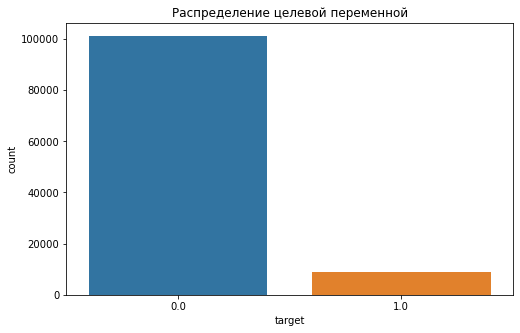

None

__Обзор номинативных признаков__

__Обзор признака «name_contract_type»__

Cash           248983
Credit Card     26251
Name: name_contract_type, dtype: int64

_Признак «name_contract_type» привели к количественным значениям_

__Обзор признака «gender»__

F      147444
M       76267
XNA         4
Name: gender, dtype: int64

_Признак «gender» привели к количественным значениям_

__Обзор признака «education_level»__

Secondary / secondary special    158887
Higher education                  54516
Incomplete higher                  7456
Lower secondary                    2736
Academic degree                     120
Name: education_level, dtype: int64

_Признак «education_level» привели к количественным значениям_

__Обзор признака «family_status»__

Married                 143149
Single / not married     32888
Civil marriage           21687
Separated                14295
Widow                    11694
Unknown                      2
Name: family_status, dtype: int64

_Признак «family_status» привели к количественным значениям_

__Обзор количественных признаков__

table_id  application_number         target  name_contract_type  \
count  275234.000000        2.752340e+05  110093.000000       275234.000000   
mean   137616.500000        1.235771e+08       0.080813            0.095377   
std     79453.356333        8.877727e+04       0.272550            0.293736   
min         0.000000        1.234233e+08       0.000000            0.000000   
25%     68808.250000        1.235003e+08       0.000000            0.000000   
50%    137616.500000        1.235771e+08       0.000000            0.000000   
75%    206424.750000        1.236540e+08       0.000000            0.000000   
max    275233.000000        1.237309e+08       1.000000            1.000000   

              gender      childrens  total_salary  amount_credit  \
count  275234.000000  223715.000000  2.237150e+05   2.237150e+05   
mean        0.651493       0.417978  1.689732e+05   5.991977e+05   
std         0.775530       0.722796  2.697500e+05   4.018597e+05   
min         0.000000       0.000000  2.565000e+04   4.500000e+04   
25%         0.000000       0.000000  1.125000e+05   2.700000e+05   
50%         0.000000       0.000000  1.485000e+05   5.175000e+05   
75%         1.000000       1.000000  2.025000e+05   8.086500e+05   
max         2.000000      19.000000  1.170000e+08   4.050000e+06   

       amount_annuity  education_level  family_status  region_population  \
count   223704.000000    275234.000000   275234.00000      223715.000000   
mean     27125.336237         0.695648        1.08278           0.020864   
std      14528.794526         0.936288        1.44753           0.013800   
min       1615.500000         0.000000        0.00000           0.000290   
25%      16524.000000         0.000000        0.00000           0.010006   
50%      24930.000000         0.000000        0.00000           0.018850   
75%      34600.500000         1.000000        2.00000           0.028663   
max     230161.500000         5.000000        6.00000           0.072508   

                 age  days_on_last_job   own_car_age     flag_phone  \
count  223715.000000     183605.000000  76034.000000  223715.000000   
mean    16031.731288       2381.686893     12.033603       0.280308   
std      4360.679026       2337.014575     11.872949       0.449150   
min      7489.000000          0.000000      0.000000       0.000000   
25%     12412.000000        765.000000      5.000000       0.000000   
50%     15745.000000       1648.000000      9.000000       0.000000   
75%     19678.000000       3175.000000     15.000000       1.000000   
max     25229.000000      17912.000000     69.000000       1.000000   

          flag_email    family_size  external_scoring_rating_1  \
count  223715.000000  223713.000000               97726.000000   
mean        0.056728       2.154801                   0.502059   
std         0.231323       0.911605                   0.210658   
min         0.000000       1.000000                   0.014691   
25%         0.000000       2.000000                   0.333954   
50%         0.000000       2.000000                   0.506102   
75%         0.000000       3.000000                   0.674368   
max         1.000000      20.000000                   0.962693   

       external_scoring_rating_2  external_scoring_rating_3  \
count              223236.000000              179308.000000   
mean                    0.513979                   0.510665   
std                     0.191094                   0.195224   
min                     0.000001                   0.000527   
25%                     0.391806                   0.368969   
50%                     0.565424                   0.535276   
75%                     0.663373                   0.669057   
max                     0.855000                   0.896010   

       amt_req_credit_bureau_hour  amt_req_credit_bureau_day  \
count               193517.000000              193517.000000   
mean                     0.006268                   0.006671   
std    

__Обзор дискретных признаков__

Всего дискретных признаков: 69


__Оценка признака «name_client_type_median» в разрезе целевой переменной__

_Признак «name_client_type_median» был удален, так как не влияет на целевую переменную_

__Оценка признака «cnt_credit_prolong_max» в разрезе целевой переменной__

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\contingency.py:244: RuntimeWarning: invalid value encountered in less
  if np.any(observed < 0):
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


_Признак «cnt_credit_prolong_max» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_goods_category_median» в разрезе целевой переменной__

_Признак «name_goods_category_median» был удален, так как не влияет на целевую переменную_

__Оценка признака «amt_req_credit_bureau_qrt» в разрезе целевой переменной__

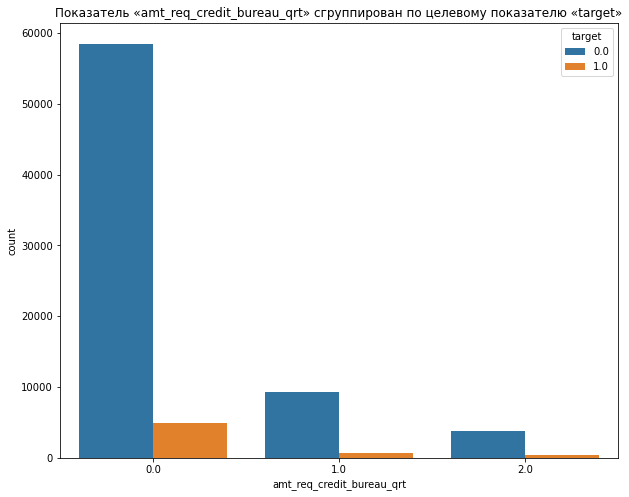

None

__Оценка признака «name_type_suite_median» в разрезе целевой переменной__

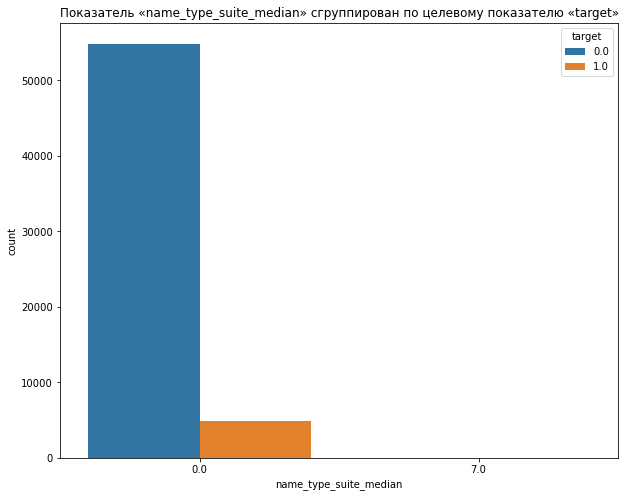

None

__Оценка признака «nflag_insured_on_approval_min» в разрезе целевой переменной__

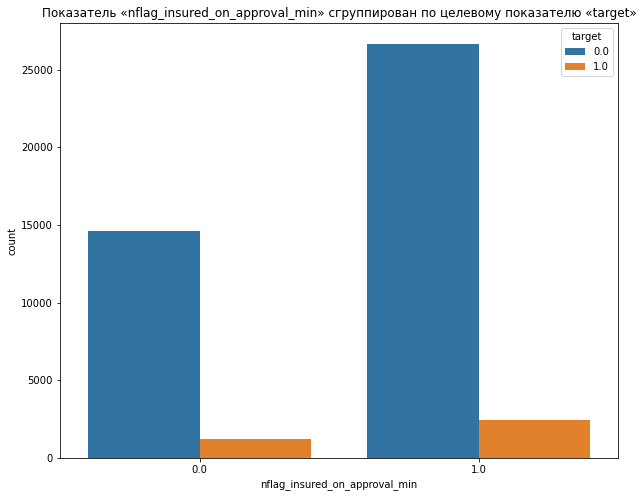

None

__Оценка признака «name_client_type_max» в разрезе целевой переменной__

_Признак «name_client_type_max» был удален, так как не влияет на целевую переменную_

__Оценка признака «nflag_insured_on_approval_sum» в разрезе целевой переменной__

_Признак «nflag_insured_on_approval_sum» был удален, так как не влияет на целевую переменную_

__Оценка признака «credit_currency_min» в разрезе целевой переменной__

_Признак «credit_currency_min» был удален, так как не влияет на целевую переменную_

__Оценка признака «cnt_credit_prolong_median» в разрезе целевой переменной__

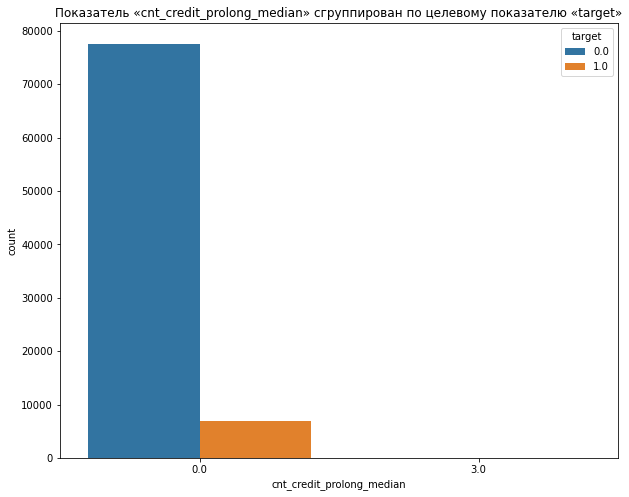

None

__Оценка признака «credit_active_median» в разрезе целевой переменной__

_Признак «credit_active_median» был удален, так как не влияет на целевую переменную_

__Оценка признака «family_status» в разрезе целевой переменной__

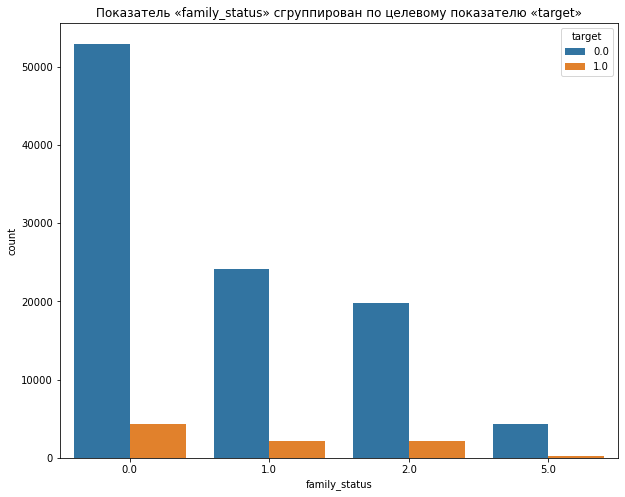

None

__Оценка признака «days_termination_count» в разрезе целевой переменной__

_Признак «days_termination_count» был удален, так как не влияет на целевую переменную_

__Оценка признака «amount_payment_std» в разрезе целевой переменной__

_Признак «amount_payment_std» был удален, так как не влияет на целевую переменную_

__Оценка признака «code_reject_reason_median» в разрезе целевой переменной__

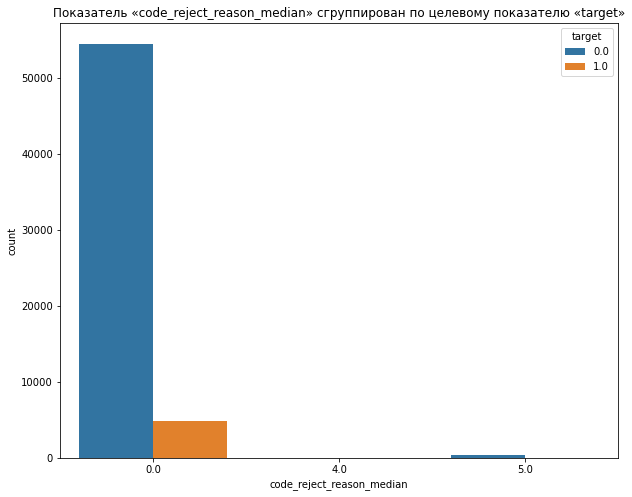

None

__Оценка признака «name_goods_category_sum» в разрезе целевой переменной__

_Признак «name_goods_category_sum» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_yield_group_min» в разрезе целевой переменной__

_Признак «name_yield_group_min» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_portfolio_min» в разрезе целевой переменной__

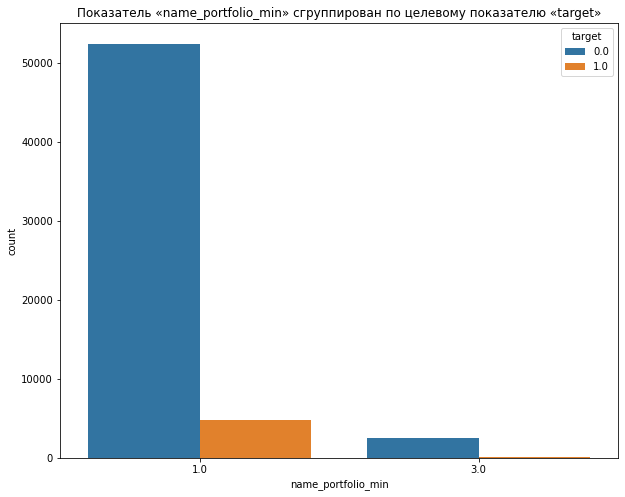

None

__Оценка признака «gender» в разрезе целевой переменной__

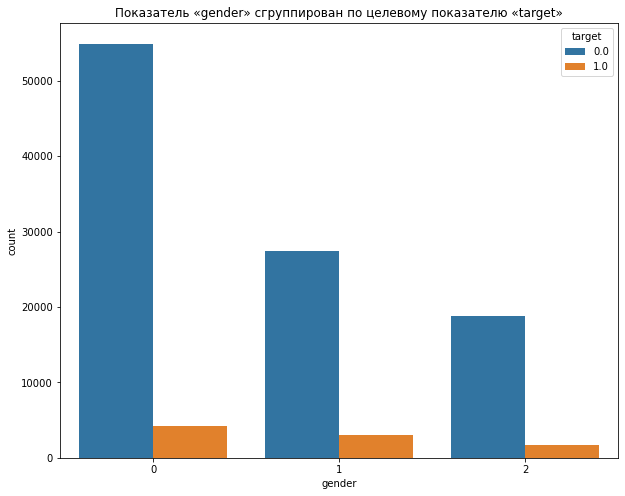

None

__Оценка признака «credit_active_max» в разрезе целевой переменной__

_Признак «credit_active_max» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_yield_group_median» в разрезе целевой переменной__

_Признак «name_yield_group_median» был удален, так как не влияет на целевую переменную_

__Оценка признака «nflag_insured_on_approval_count» в разрезе целевой переменной__

_Признак «nflag_insured_on_approval_count» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_contract_status_min» в разрезе целевой переменной__

_Признак «name_contract_status_min» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_product_type_min» в разрезе целевой переменной__

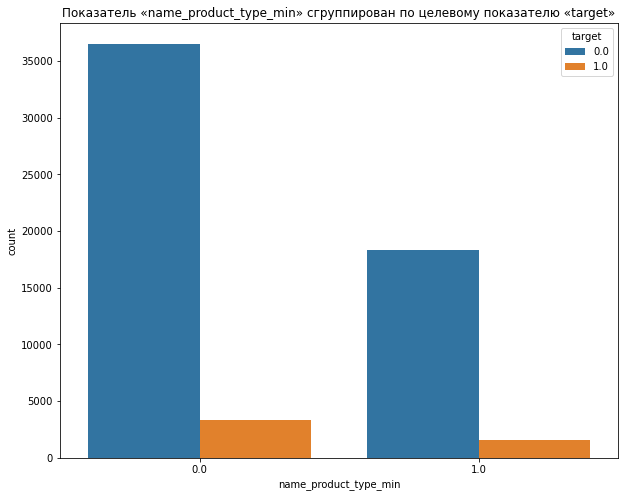

None

__Оценка признака «name_client_type_min» в разрезе целевой переменной__

_Признак «name_client_type_min» был удален, так как не влияет на целевую переменную_

__Оценка признака «flag_email» в разрезе целевой переменной__

_Признак «flag_email» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_payment_type_min» в разрезе целевой переменной__

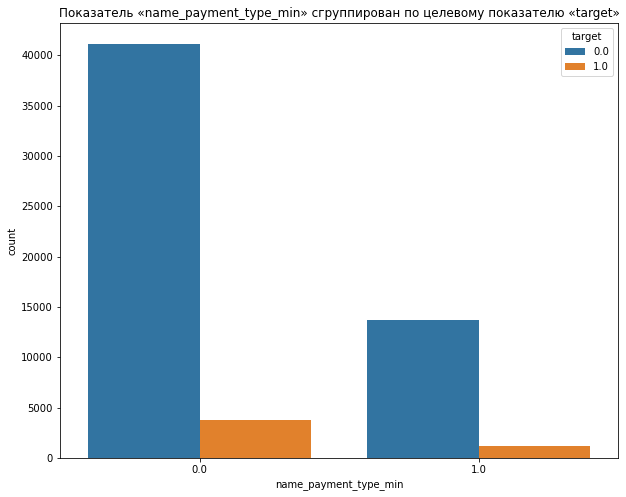

None

__Оценка признака «amt_credit_max_overdue_count» в разрезе целевой переменной__

_Признак «amt_credit_max_overdue_count» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_contract_status_median» в разрезе целевой переменной__

_Признак «name_contract_status_median» был удален, так как не влияет на целевую переменную_

__Оценка признака «credit_active_sum» в разрезе целевой переменной__

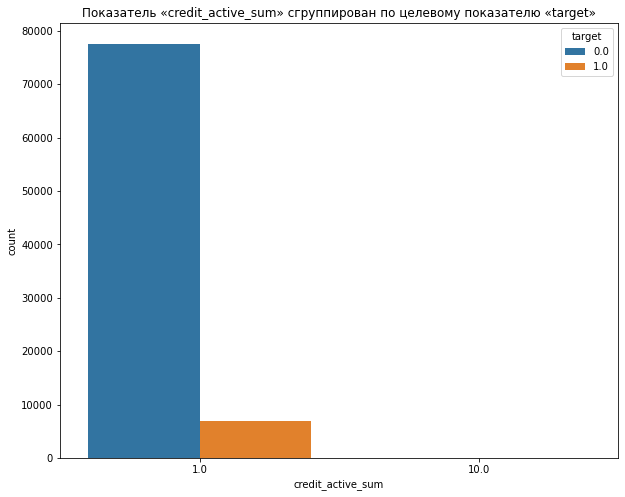

None

__Оценка признака «credit_type_max» в разрезе целевой переменной__

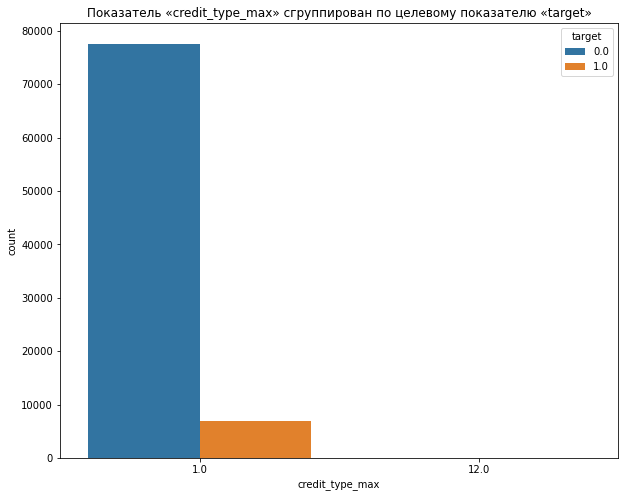

None

__Оценка признака «credit_currency_sum» в разрезе целевой переменной__

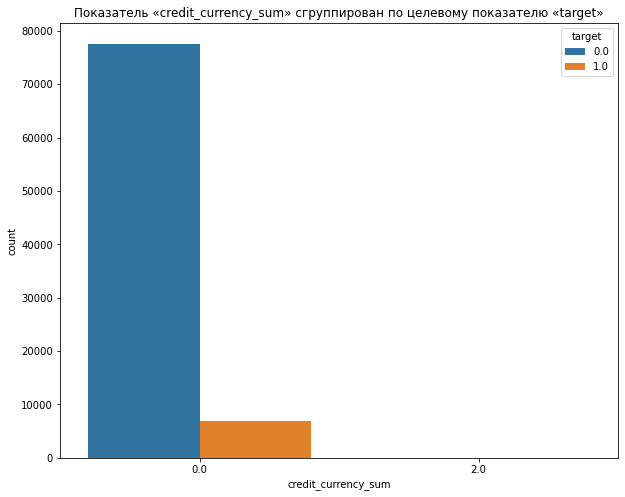

None

__Оценка признака «credit_currency_max» в разрезе целевой переменной__

_Признак «credit_currency_max» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_type_suite_max» в разрезе целевой переменной__

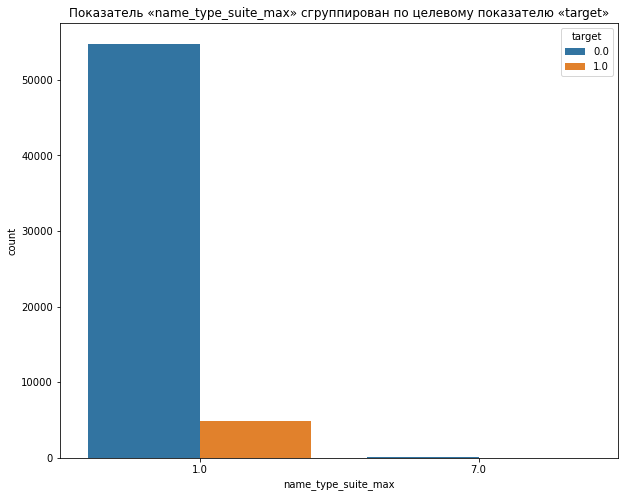

None

__Оценка признака «amt_req_credit_bureau_day» в разрезе целевой переменной__

_Признак «amt_req_credit_bureau_day» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_goods_category_max» в разрезе целевой переменной__

_Признак «name_goods_category_max» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_product_type_median» в разрезе целевой переменной__

_Признак «name_product_type_median» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_goods_category_std» в разрезе целевой переменной__

_Признак «name_goods_category_std» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_goods_category_mean» в разрезе целевой переменной__

_Признак «name_goods_category_mean» был удален, так как не влияет на целевую переменную_

__Оценка признака «family_size» в разрезе целевой переменной__

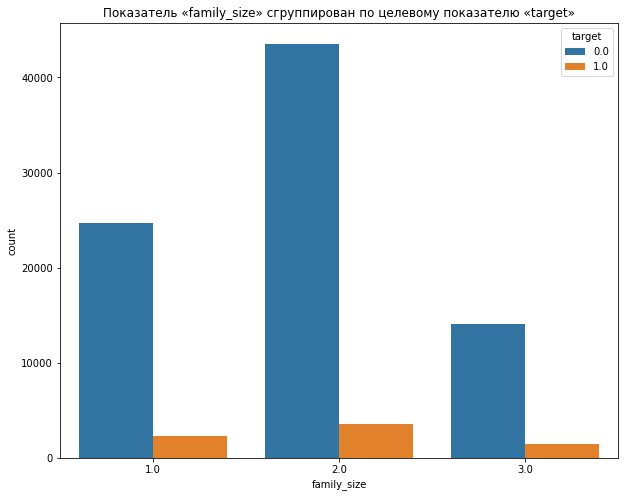

None

__Оценка признака «name_contract_status_max» в разрезе целевой переменной__

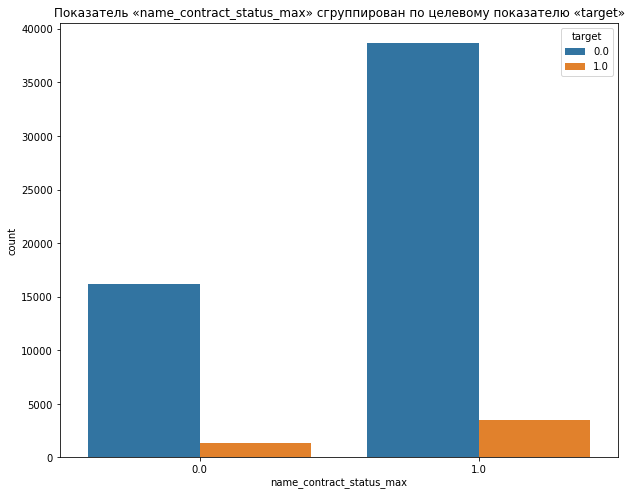

None

__Оценка признака «credit_active_min» в разрезе целевой переменной__

_Признак «credit_active_min» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_portfolio_median» в разрезе целевой переменной__

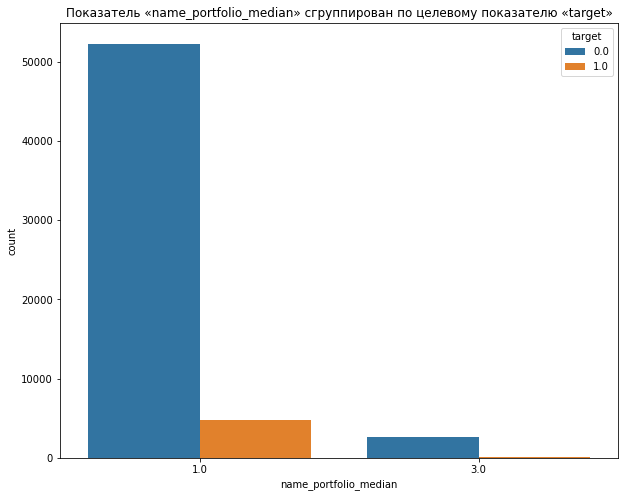

None

__Оценка признака «days_first_due_count» в разрезе целевой переменной__

_Признак «days_first_due_count» был удален, так как не влияет на целевую переменную_

__Оценка признака «days_last_due_count» в разрезе целевой переменной__

_Признак «days_last_due_count» был удален, так как не влияет на целевую переменную_

__Оценка признака «credit_currency_median» в разрезе целевой переменной__

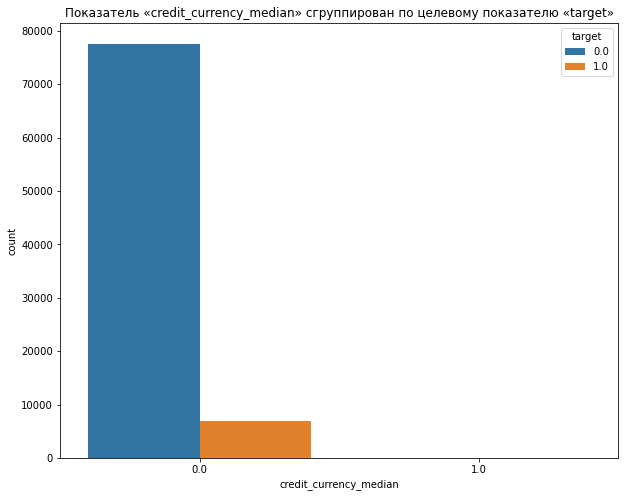

None

__Оценка признака «childrens» в разрезе целевой переменной__

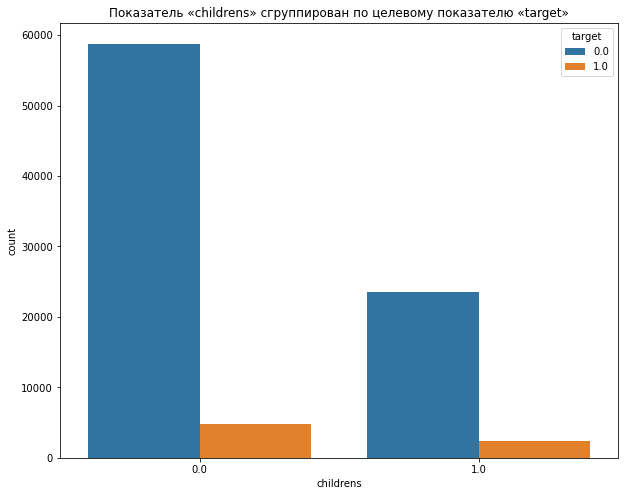

None

__Оценка признака «days_last_due_1st_version_count» в разрезе целевой переменной__

_Признак «days_last_due_1st_version_count» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_goods_category_min» в разрезе целевой переменной__

_Признак «name_goods_category_min» был удален, так как не влияет на целевую переменную_

__Оценка признака «code_reject_reason_max» в разрезе целевой переменной__

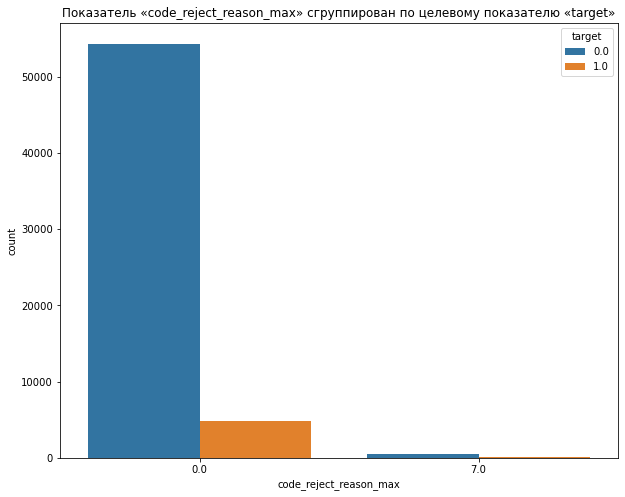

None

__Оценка признака «credit_type_min» в разрезе целевой переменной__

_Признак «credit_type_min» был удален, так как не влияет на целевую переменную_

__Оценка признака «days_first_drawing_count» в разрезе целевой переменной__

_Признак «days_first_drawing_count» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_payment_type_max» в разрезе целевой переменной__

_Признак «name_payment_type_max» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_contract_type» в разрезе целевой переменной__

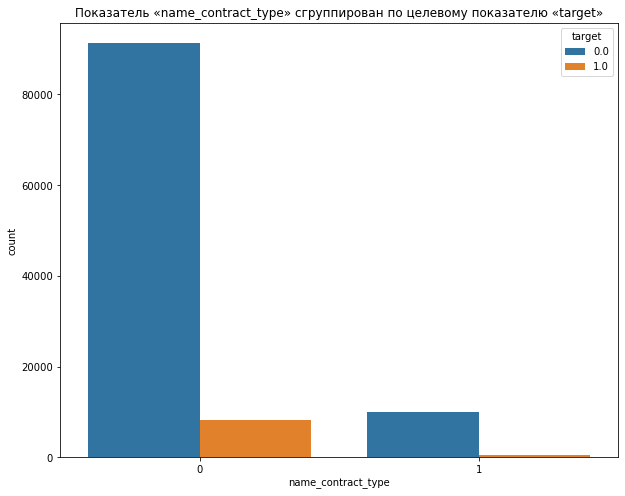

None

__Оценка признака «nflag_insured_on_approval_max» в разрезе целевой переменной__

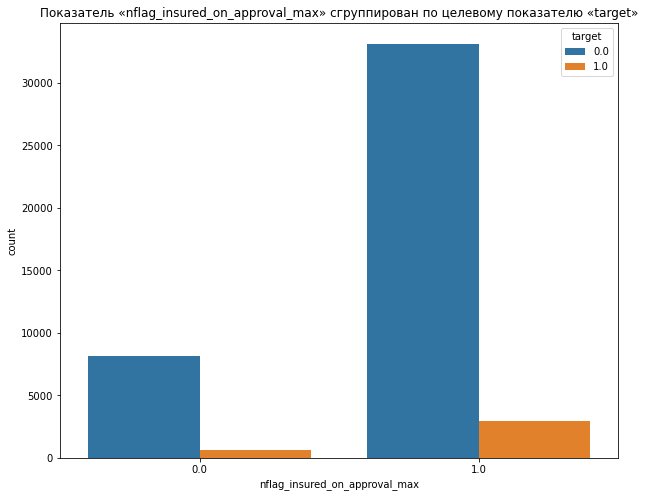

None

__Оценка признака «name_type_suite_min» в разрезе целевой переменной__

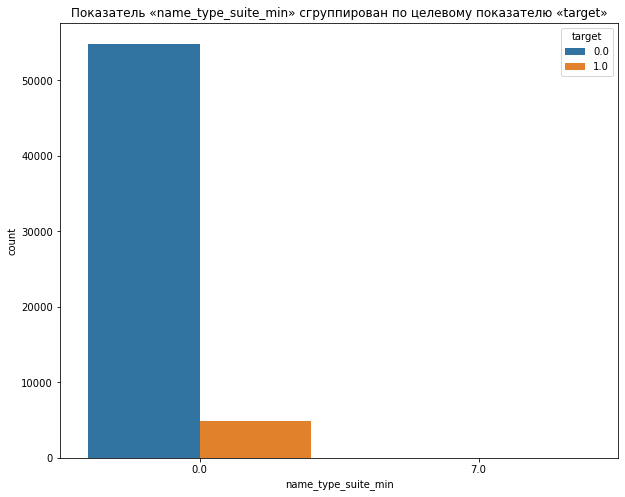

None

__Оценка признака «cnt_credit_prolong_min» в разрезе целевой переменной__

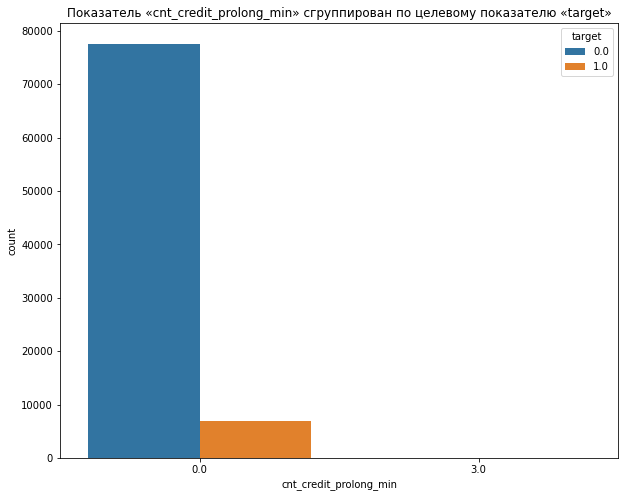

None

__Оценка признака «name_payment_type_median» в разрезе целевой переменной__

_Признак «name_payment_type_median» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_portfolio_max» в разрезе целевой переменной__

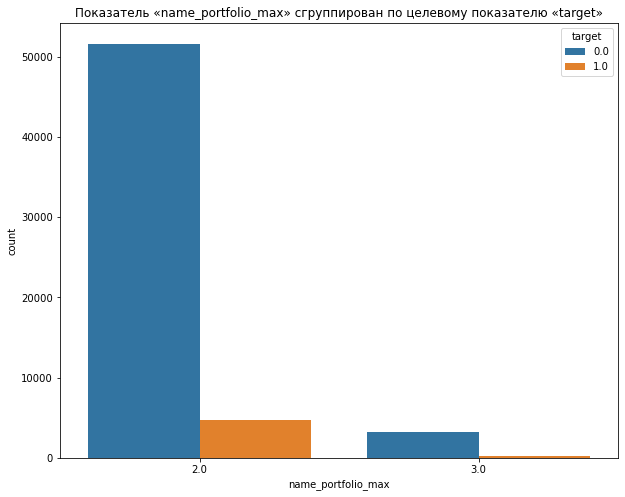

None

__Оценка признака «nflag_insured_on_approval_median» в разрезе целевой переменной__

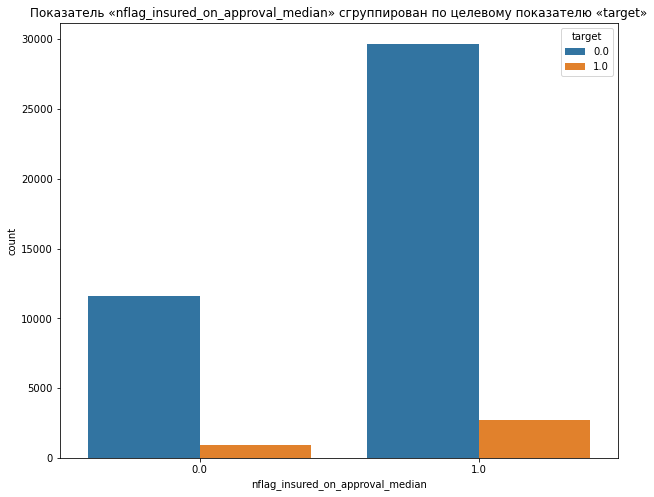

None

__Оценка признака «flag_phone» в разрезе целевой переменной__

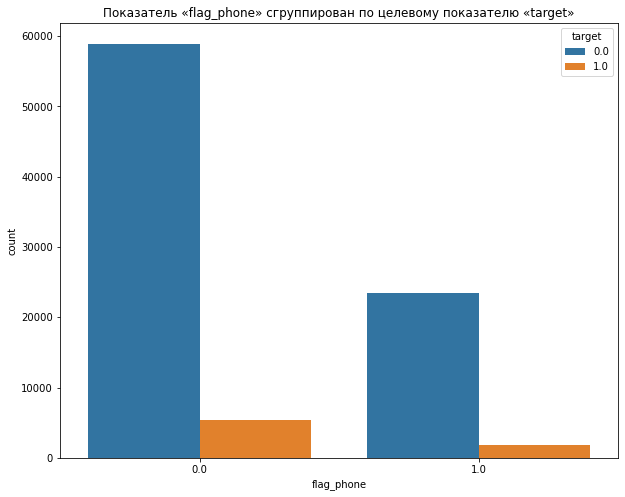

None

__Оценка признака «code_reject_reason_min» в разрезе целевой переменной__

_Признак «code_reject_reason_min» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_yield_group_max» в разрезе целевой переменной__

_Признак «name_yield_group_max» был удален, так как не влияет на целевую переменную_

__Оценка признака «name_product_type_max» в разрезе целевой переменной__

_Признак «name_product_type_max» был удален, так как не влияет на целевую переменную_

__Оценка признака «cnt_credit_prolong_sum» в разрезе целевой переменной__

_Признак «cnt_credit_prolong_sum» был удален, так как не влияет на целевую переменную_

__Оценка признака «credit_type_median» в разрезе целевой переменной__

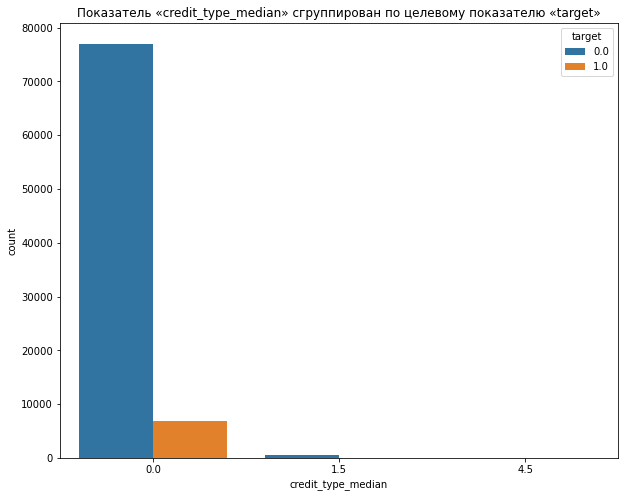

None

__Оценка признака «amt_req_credit_bureau_hour» в разрезе целевой переменной__

_Признак «amt_req_credit_bureau_hour» был удален, так как не влияет на целевую переменную_

__Оценка признака «education_level» в разрезе целевой переменной__

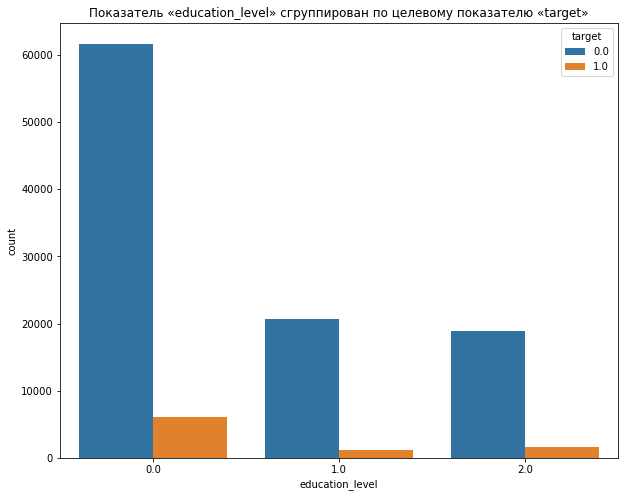

None

__Оценка признака «amt_req_credit_bureau_week» в разрезе целевой переменной__

_Признак «amt_req_credit_bureau_week» был удален, так как не влияет на целевую переменную_

__Обзор непрерывных признаков__

__Оценка признака «ratio_car_to_experience» в разрезе целевой переменной__

_Привели к нормальному распределению_

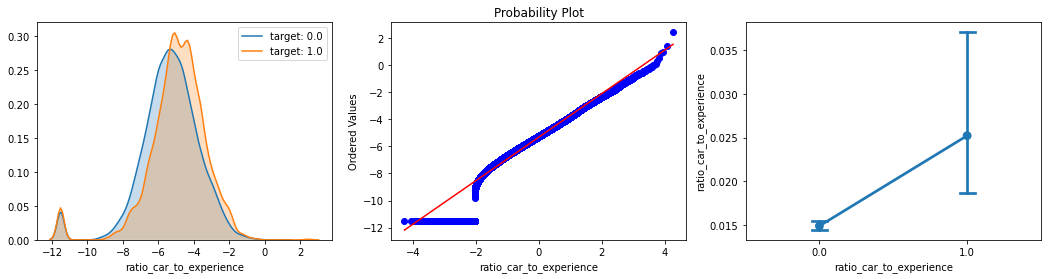

None

__Оценка признака «credit_day_overdue_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_day_overdue_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «external_scoring_rating_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

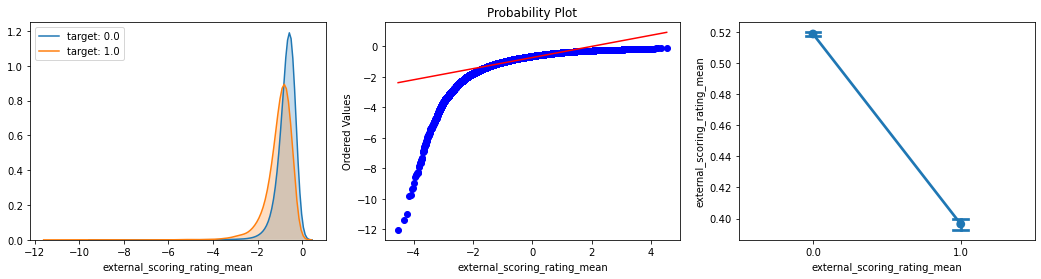

None

__Оценка признака «bki_kurtosis» в разрезе целевой переменной__

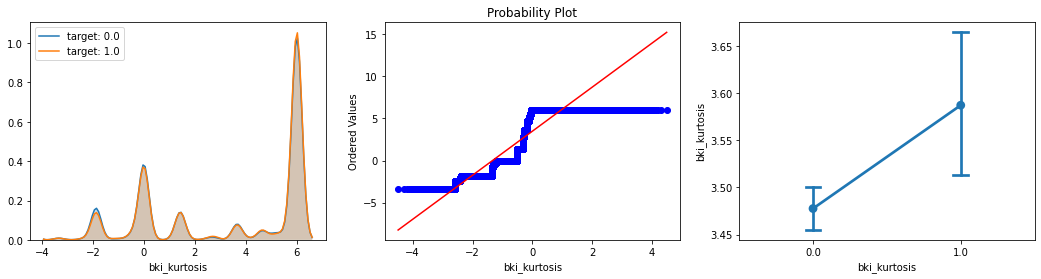

None

__Оценка признака «days_termination_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_termination_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_application_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_application_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_application_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_application_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_first_drawing_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

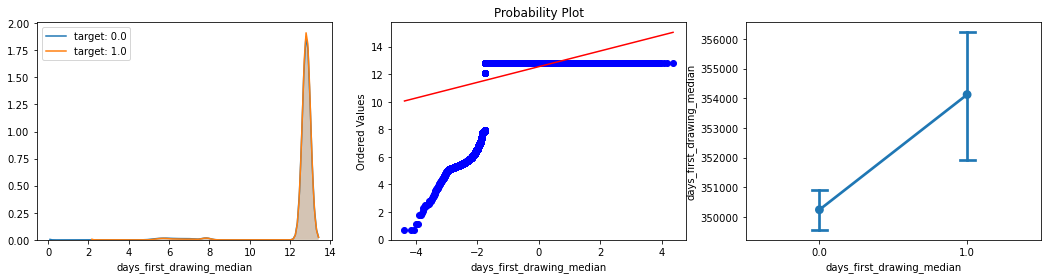

None

__Оценка признака «days_last_due_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_last_due_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_first_drawing_std» в разрезе целевой переменной__

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


_Удаляем слобец «days_first_drawing_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_overdue_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_overdue_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_client_type_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_client_type_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_application_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_application_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «bureau_id_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «bureau_id_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_first_due_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

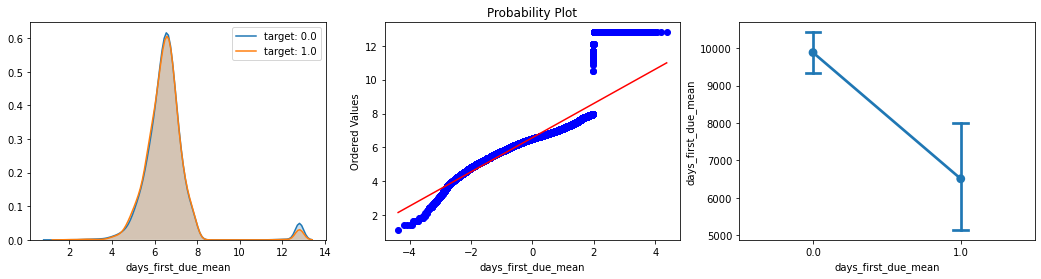

None

__Оценка признака «amt_application_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_application_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_application_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_application_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_instalment_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_instalment_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «sellerplace_area_min» в разрезе целевой переменной__

_Удаляем слобец «sellerplace_area_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_max_overdue_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_max_overdue_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_payment_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

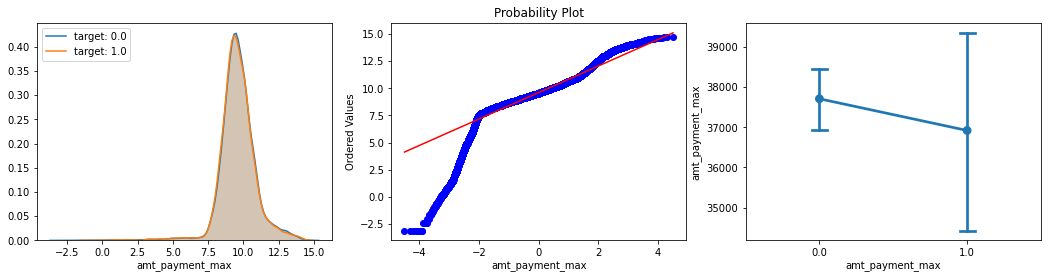

None

__Оценка признака «bureau_id_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «bureau_id_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_debt_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_debt_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_decision_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

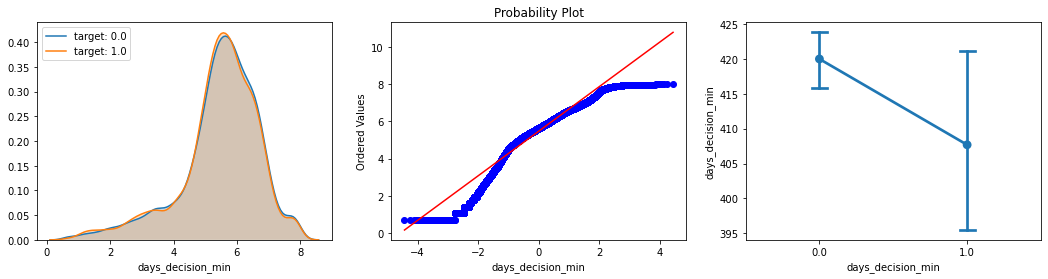

None

__Оценка признака «amt_credit_sum_limit_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_limit_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_annuity_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_annuity_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «cnt_payment_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «cnt_payment_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_req_credit_bureau_mon» в разрезе целевой переменной__

_Привели к нормальному распределению_

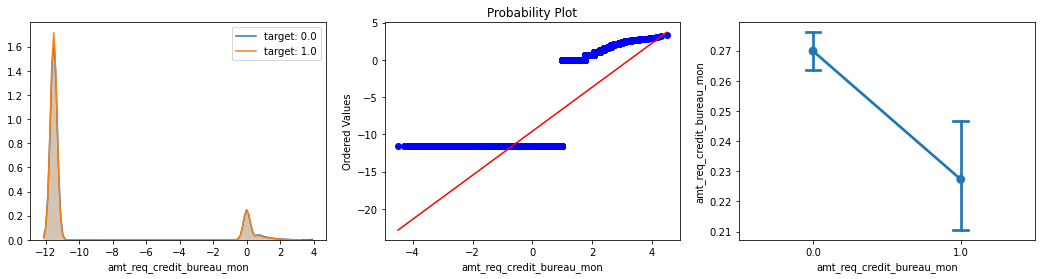

None

__Оценка признака «amount_payment_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_payment_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «num_instalment_number_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «num_instalment_number_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_last_due_1st_version_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

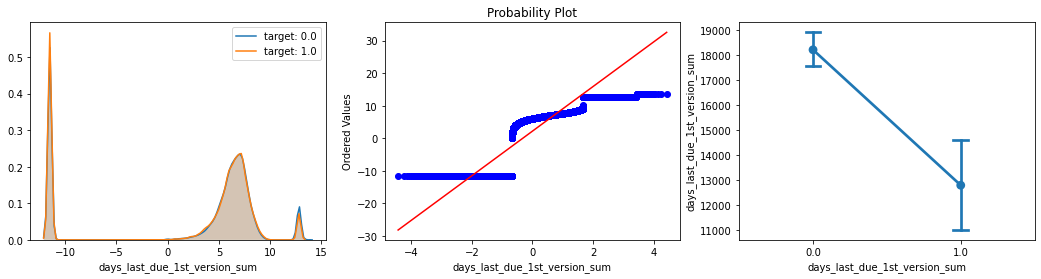

None

__Оценка признака «external_scoring_weighted» в разрезе целевой переменной__

_Привели к нормальному распределению_

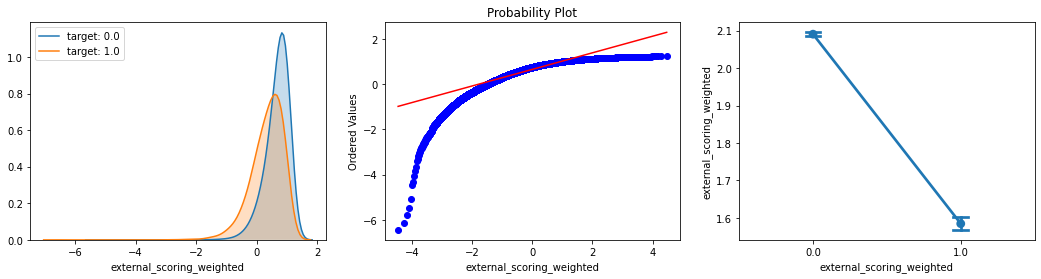

None

__Оценка признака «amt_instalment_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_instalment_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_first_due_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_first_due_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_termination_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_termination_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_instalment_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_instalment_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_type_suite_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_type_suite_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «prev_application_number_y_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «prev_application_number_y_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_credit_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_limit_median» в разрезе целевой переменной__

_Удаляем слобец «amt_credit_sum_limit_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «credit_type_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_type_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «bureau_id_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «bureau_id_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_credit_update_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_update_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «bki_requests_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

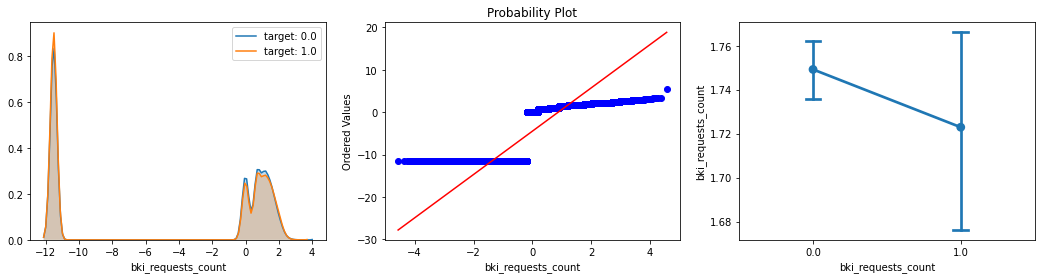

None

__Оценка признака «credit_active_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_active_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «prev_application_number_y_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «prev_application_number_y_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_goods_payment_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_goods_payment_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «expected_total_loss_3» в разрезе целевой переменной__

_Привели к нормальному распределению_

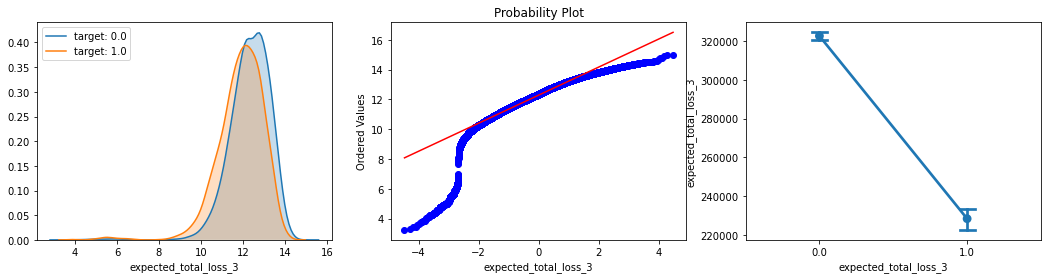

None

__Оценка признака «amount_goods_payment_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_goods_payment_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «sellerplace_area_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «sellerplace_area_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_annuity_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_annuity_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_limit_mean» в разрезе целевой переменной__

_Удаляем слобец «amt_credit_sum_limit_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «external_scoring_rating_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

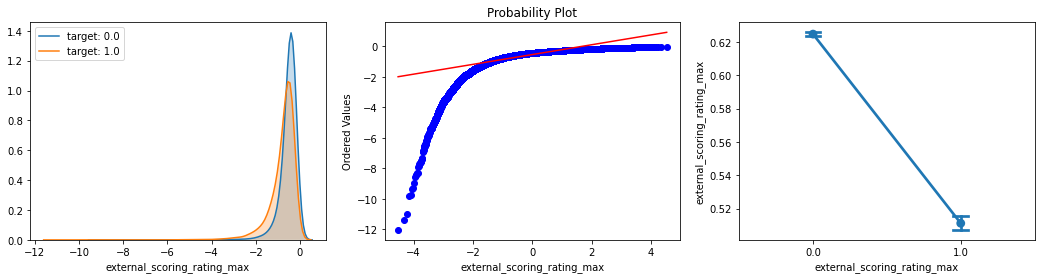

None

__Оценка признака «name_portfolio_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_portfolio_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «ratio_salary_to_region_population» в разрезе целевой переменной__

_Привели к нормальному распределению_

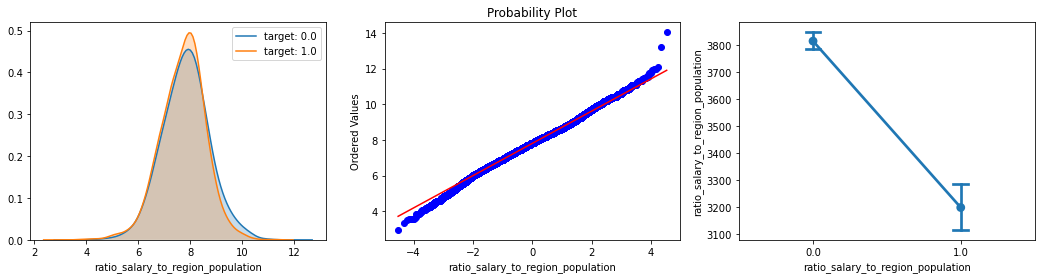

None

__Оценка признака «amt_credit_max_overdue_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_max_overdue_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_goods_payment_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_goods_payment_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «ratio_annuity_to_salary» в разрезе целевой переменной__

_Привели к нормальному распределению_

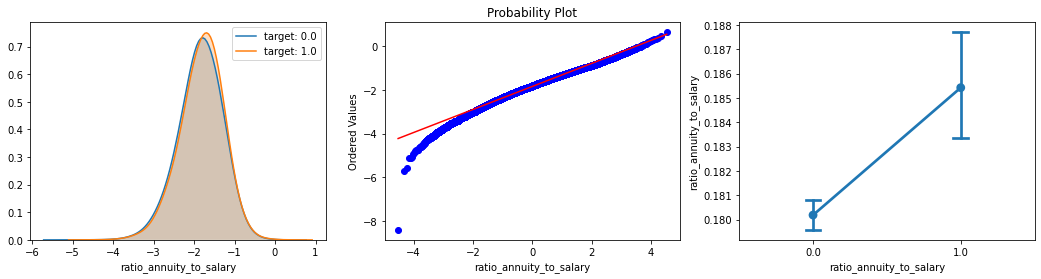

None

__Оценка признака «amount_credit_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_credit_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_credit_enddate_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_enddate_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_enddate_fact_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_enddate_fact_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_payment_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_payment_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_credit_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_contract_status_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

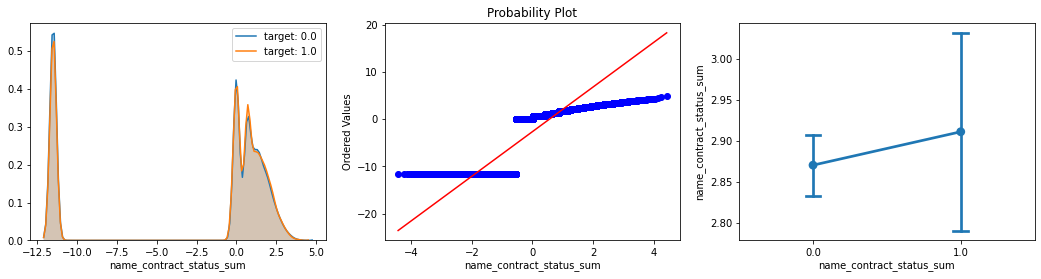

None

__Оценка признака «num_instalment_version_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «num_instalment_version_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_payment_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_payment_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_payment_type_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_payment_type_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_portfolio_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_portfolio_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_product_type_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_product_type_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «external_scoring_rating_nanmedian» в разрезе целевой переменной__

_Привели к нормальному распределению_

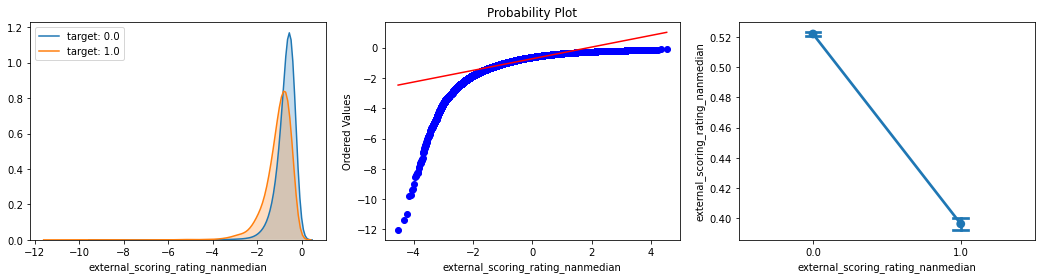

None

__Оценка признака «num_instalment_version_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

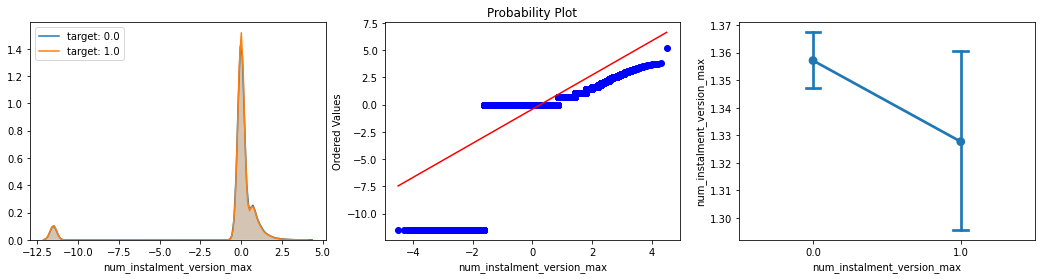

None

__Оценка признака «days_entry_payment_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_entry_payment_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_goods_payment_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_goods_payment_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_entry_payment_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_entry_payment_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_product_type_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_product_type_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «credit_currency_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_currency_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_overdue_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_overdue_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_goods_payment_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_goods_payment_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_last_due_1st_version_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

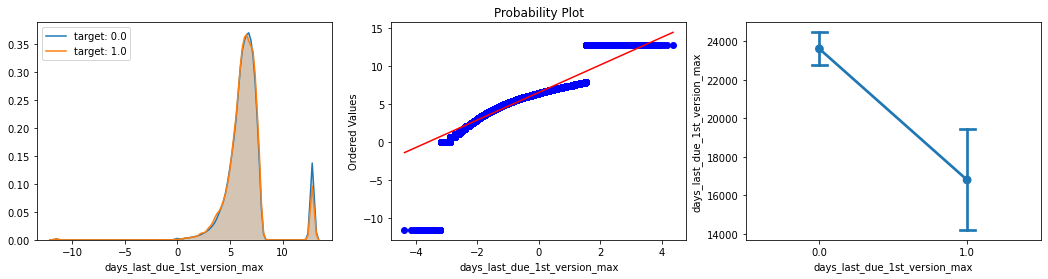

None

__Оценка признака «region_population» в разрезе целевой переменной__

_Привели к нормальному распределению_

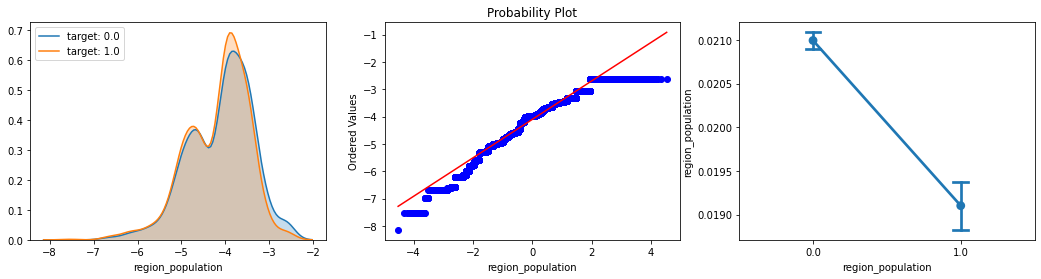

None

__Оценка признака «ratio_car_to_age» в разрезе целевой переменной__

_Привели к нормальному распределению_

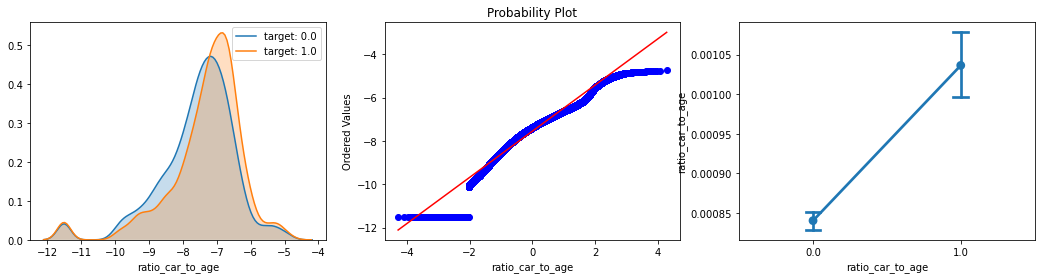

None

__Оценка признака «amt_instalment_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_instalment_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «code_reject_reason_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «code_reject_reason_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «cnt_payment_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «cnt_payment_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_overdue_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_overdue_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_first_drawing_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_first_drawing_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «num_instalment_number_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «num_instalment_number_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_yield_group_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_yield_group_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_payment_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

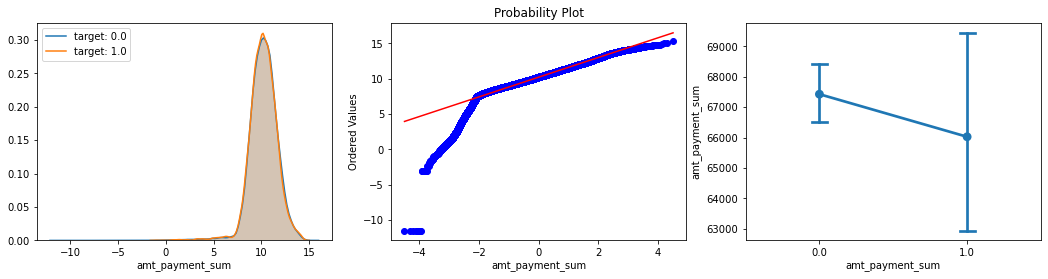

None

__Оценка признака «ratio_credit_to_salary» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «ratio_credit_to_salary» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_instalment_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

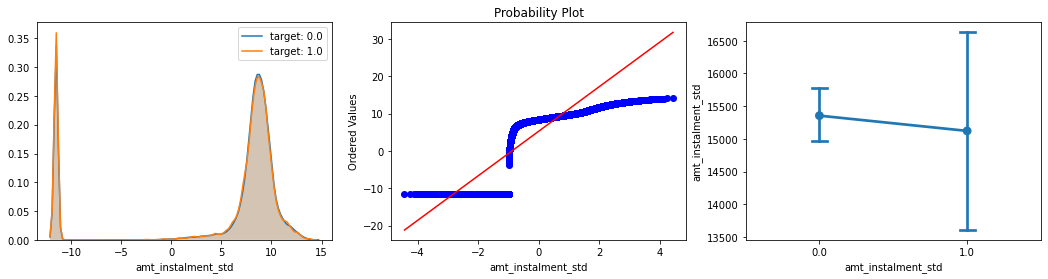

None

__Оценка признака «name_yield_group_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_yield_group_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «ratio_annuity_to_age» в разрезе целевой переменной__

_Привели к нормальному распределению_

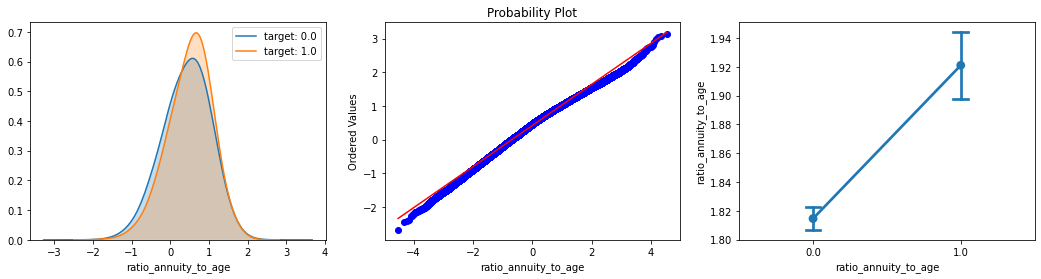

None

__Оценка признака «days_credit_enddate_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_enddate_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «total_salary_net» в разрезе целевой переменной__

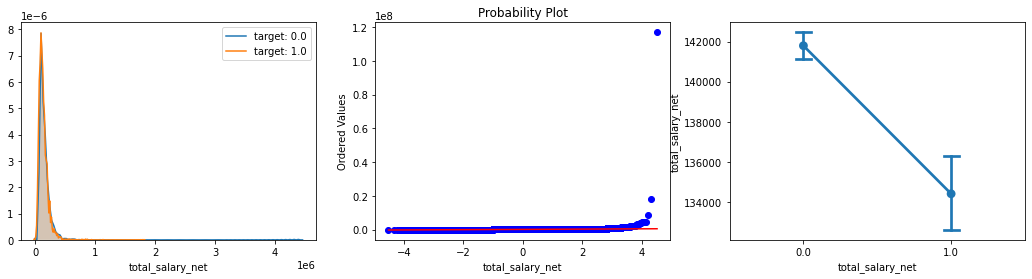

None

__Оценка признака «days_decision_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_decision_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_first_drawing_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

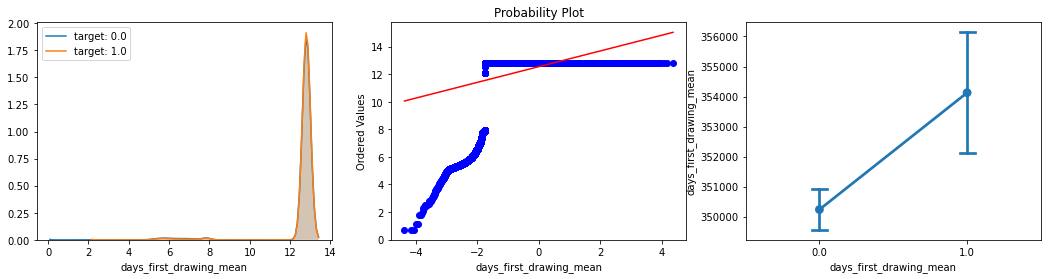

None

__Оценка признака «amt_credit_sum_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_credit_update_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_update_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_annuity_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_annuity_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_annuity_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_annuity_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «prev_application_number_median_x» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «prev_application_number_median_x» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «prev_application_number_count_x» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «prev_application_number_count_x» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_entry_payment_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_entry_payment_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_credit_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «ratio_credit_to_age» в разрезе целевой переменной__

_Привели к нормальному распределению_

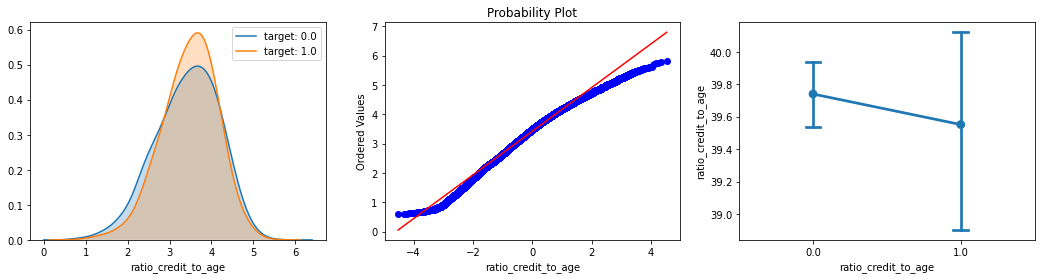

None

__Оценка признака «prev_application_number_y_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «prev_application_number_y_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_overdue_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_overdue_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «sellerplace_area_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «sellerplace_area_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «num_instalment_version_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «num_instalment_version_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «credit_day_overdue_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_day_overdue_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_last_due_1st_version_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_last_due_1st_version_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «cnt_payment_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

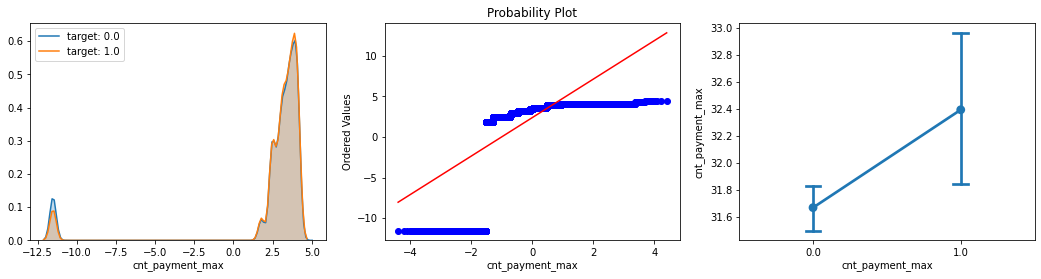

None

__Оценка признака «amt_credit_sum_debt_sum» в разрезе целевой переменной__

_Удаляем слобец «amt_credit_sum_debt_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_contract_status_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_contract_status_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_credit_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «num_instalment_number_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «num_instalment_number_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_termination_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_termination_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_max_overdue_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_max_overdue_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_debt_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_debt_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_enddate_fact_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_enddate_fact_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_decision_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_decision_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «code_reject_reason_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «code_reject_reason_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «num_instalment_number_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «num_instalment_number_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_decision_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_decision_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_client_type_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_client_type_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_debt_median» в разрезе целевой переменной__

_Удаляем слобец «amt_credit_sum_debt_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «ratio_credit_to_annuity» в разрезе целевой переменной__

_Привели к нормальному распределению_

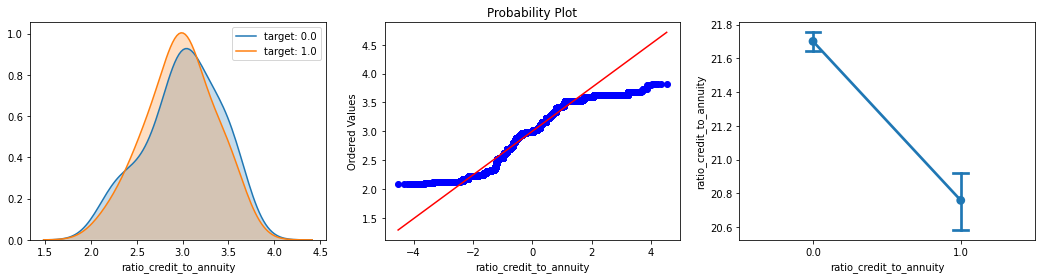

None

__Оценка признака «days_first_drawing_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

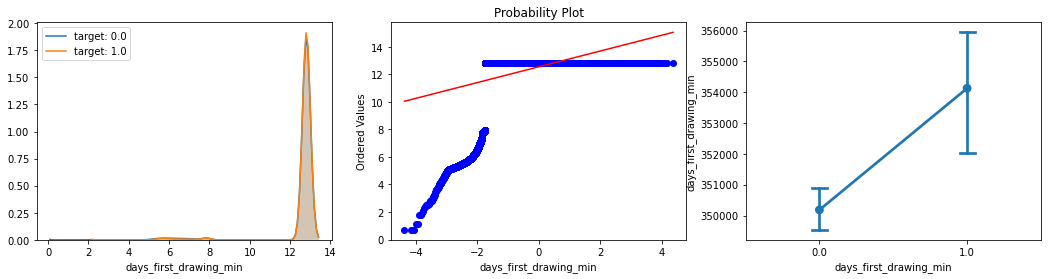

None

__Оценка признака «days_instalment_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_instalment_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_enddate_fact_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_enddate_fact_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_payment_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

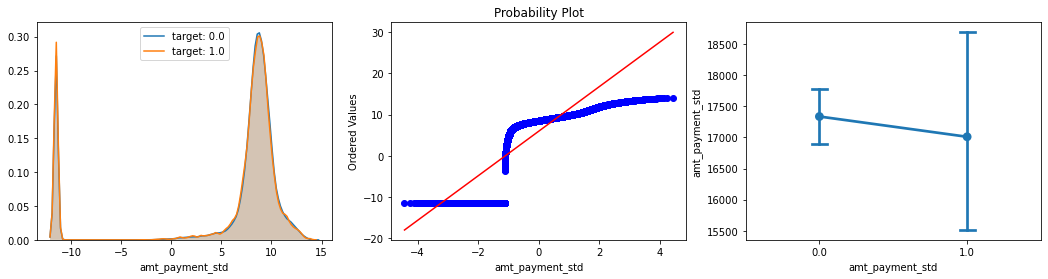

None

__Оценка признака «days_entry_payment_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_entry_payment_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_credit_enddate_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_enddate_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_entry_payment_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_entry_payment_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «bureau_id_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «bureau_id_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «code_reject_reason_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «code_reject_reason_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_payment_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_payment_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_product_type_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_product_type_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_yield_group_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_yield_group_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «code_reject_reason_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «code_reject_reason_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «num_instalment_number_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «num_instalment_number_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_overdue_min» в разрезе целевой переменной__

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


_Удаляем слобец «amt_credit_sum_overdue_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «prev_application_number_y_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

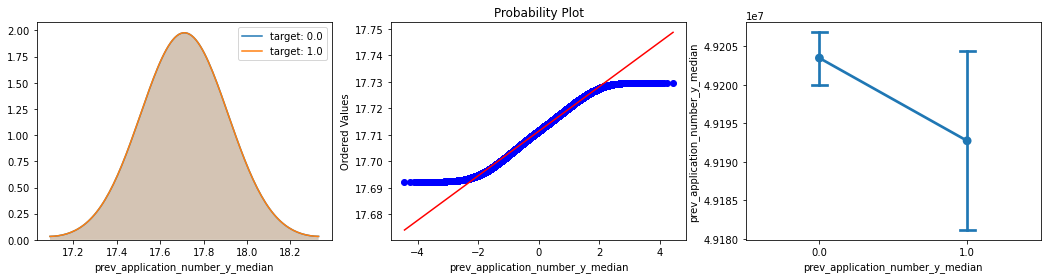

None

__Оценка признака «days_entry_payment_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_entry_payment_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «expected_monthly_loss_2» в разрезе целевой переменной__

_Привели к нормальному распределению_

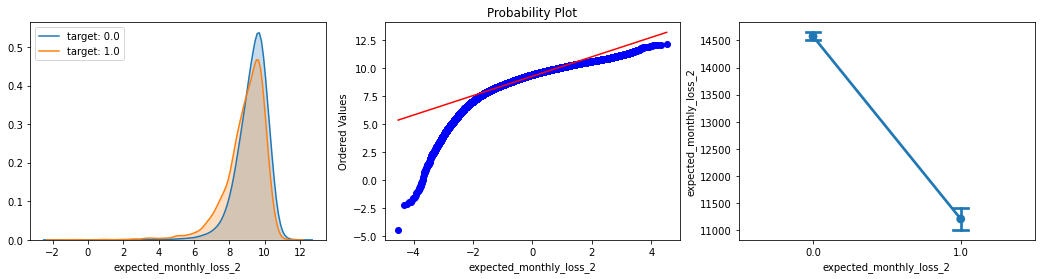

None

__Оценка признака «name_type_suite_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_type_suite_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «own_car_age» в разрезе целевой переменной__

_Привели к нормальному распределению_

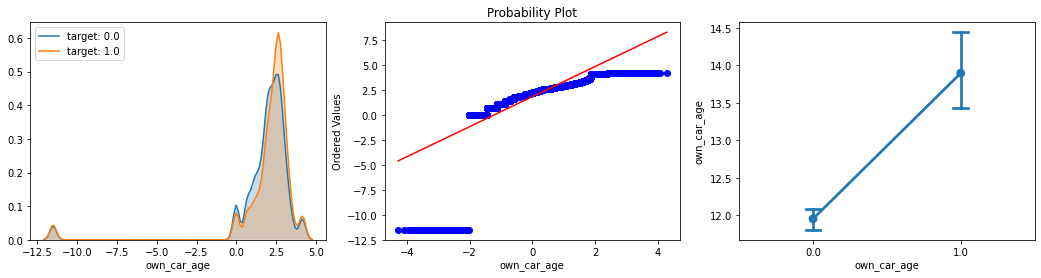

None

__Оценка признака «external_scoring_prod» в разрезе целевой переменной__

_Привели к нормальному распределению_

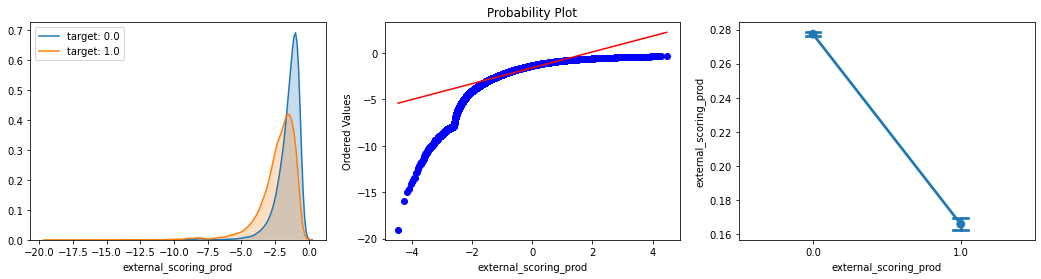

None

__Оценка признака «amt_credit_sum_debt_min» в разрезе целевой переменной__

_Удаляем слобец «amt_credit_sum_debt_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_payment_type_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_payment_type_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «prev_application_number_y_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «prev_application_number_y_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_last_due_1st_version_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_last_due_1st_version_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_portfolio_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_portfolio_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «ratio_credit_to_experience» в разрезе целевой переменной__

_Привели к нормальному распределению_

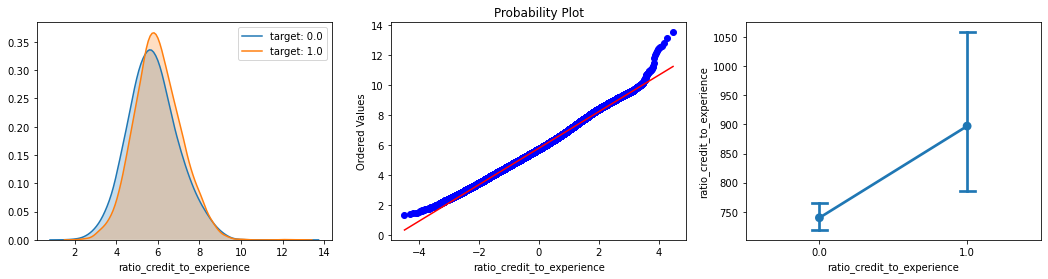

None

__Оценка признака «name_goods_category_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_goods_category_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «expected_monthly_loss_3» в разрезе целевой переменной__

_Привели к нормальному распределению_

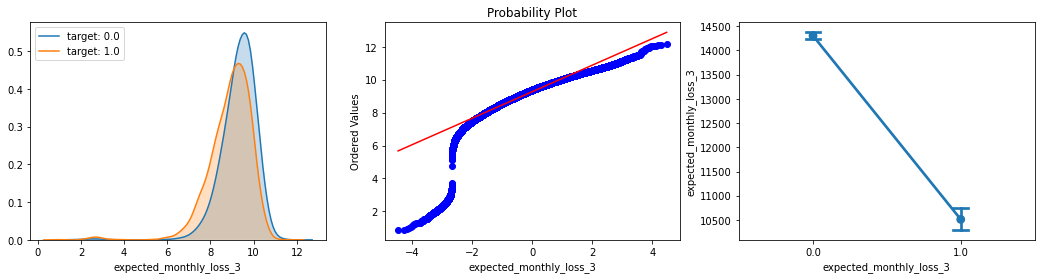

None

__Оценка признака «name_client_type_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_client_type_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «external_scoring_rating_3» в разрезе целевой переменной__

_Привели к нормальному распределению_

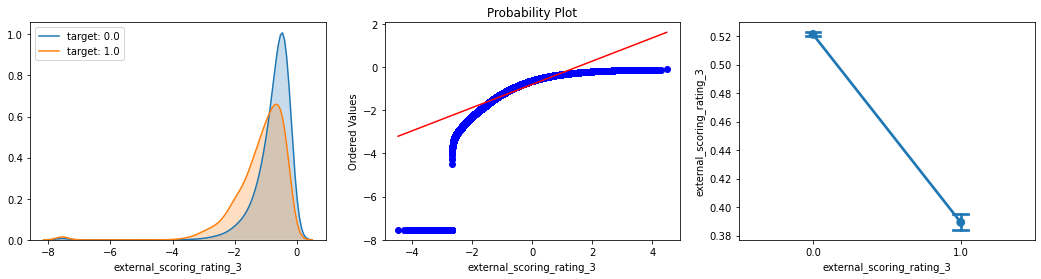

None

__Оценка признака «num_instalment_version_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

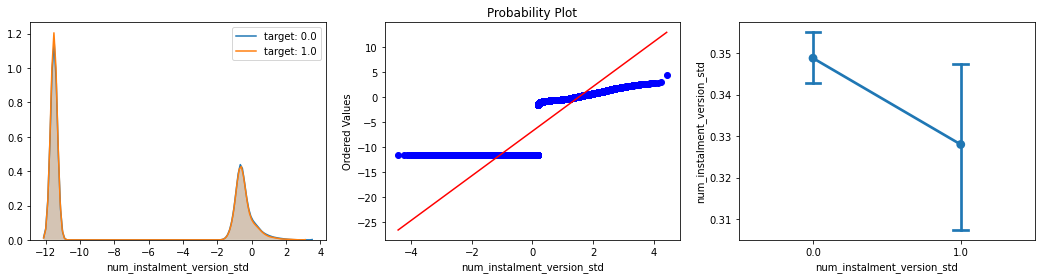

None

__Оценка признака «days_credit_enddate_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_enddate_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_goods_payment_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_goods_payment_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «expected_total_loss_2» в разрезе целевой переменной__

_Привели к нормальному распределению_

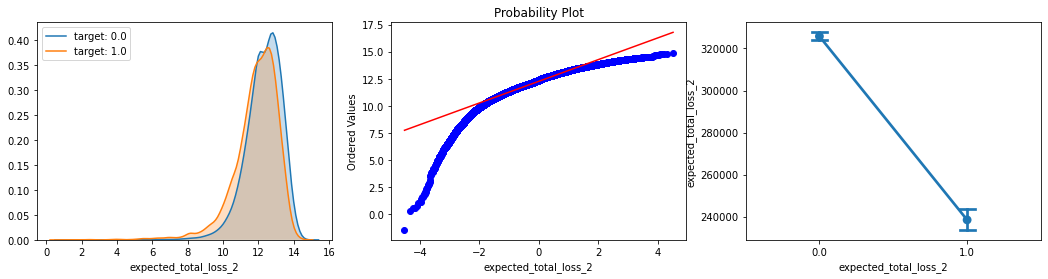

None

__Оценка признака «credit_day_overdue_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_day_overdue_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «cnt_credit_prolong_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «cnt_credit_prolong_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «cnt_payment_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

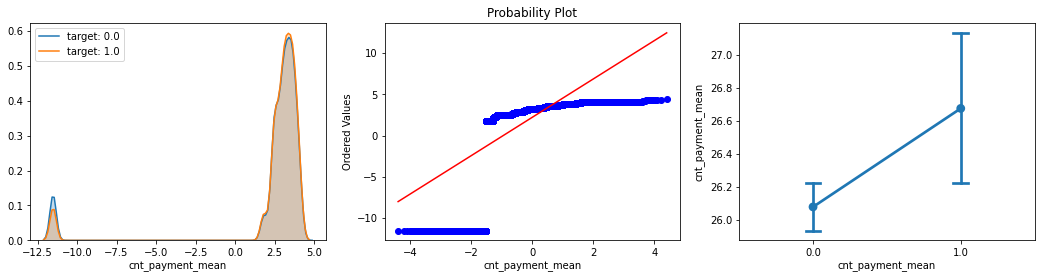

None

__Оценка признака «name_payment_type_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_payment_type_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_first_due_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

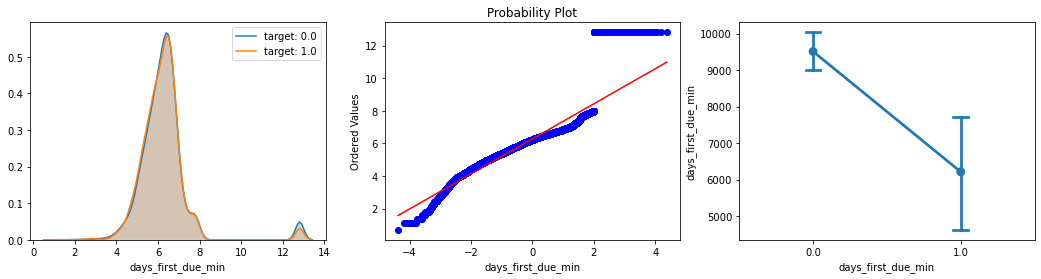

None

__Оценка признака «ratio_age_to_experience» в разрезе целевой переменной__

_Привели к нормальному распределению_

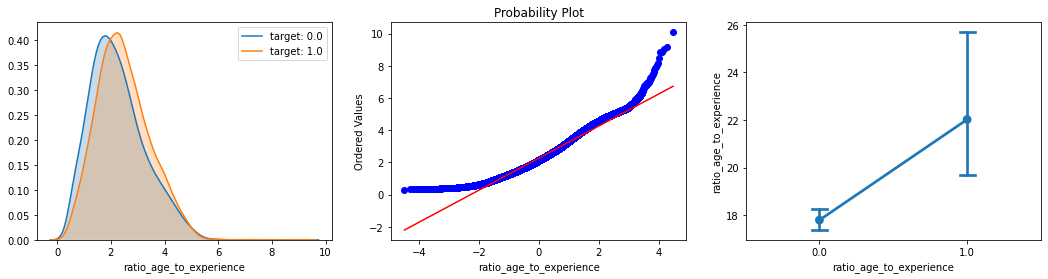

None

__Оценка признака «credit_currency_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_currency_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_instalment_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

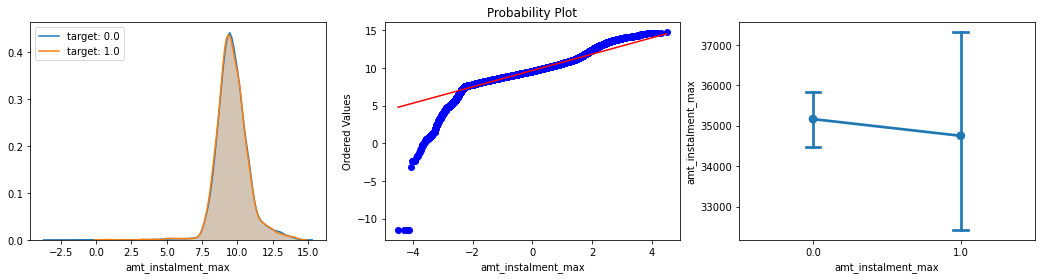

None

__Оценка признака «days_termination_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_termination_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «expected_monthly_loss_1» в разрезе целевой переменной__

_Привели к нормальному распределению_

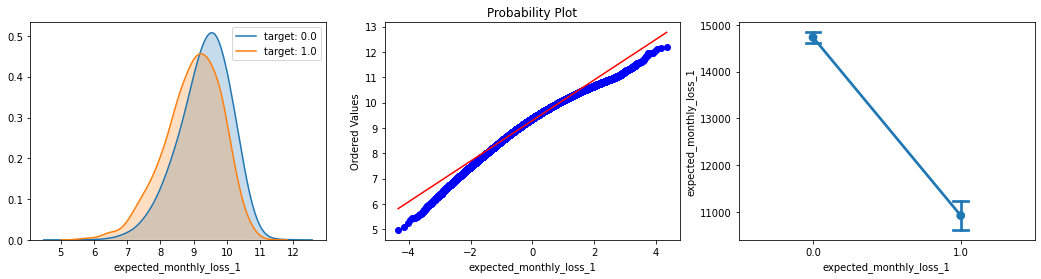

None

__Оценка признака «amount_annuity_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_annuity_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «bureau_id_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «bureau_id_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_payment_type_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

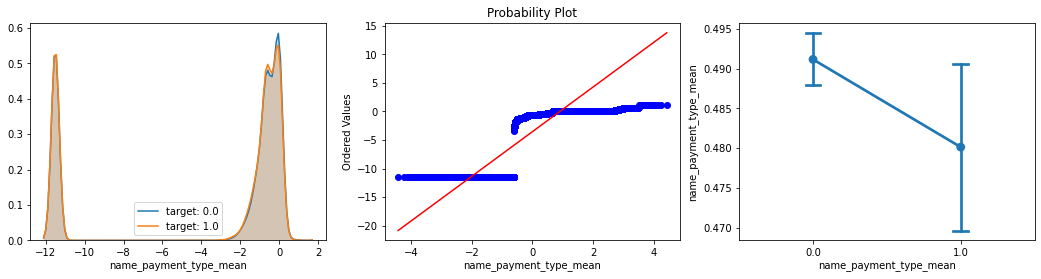

None

__Оценка признака «sellerplace_area_median» в разрезе целевой переменной__

_Удаляем слобец «sellerplace_area_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «total_salary» в разрезе целевой переменной__

_Привели к нормальному распределению_

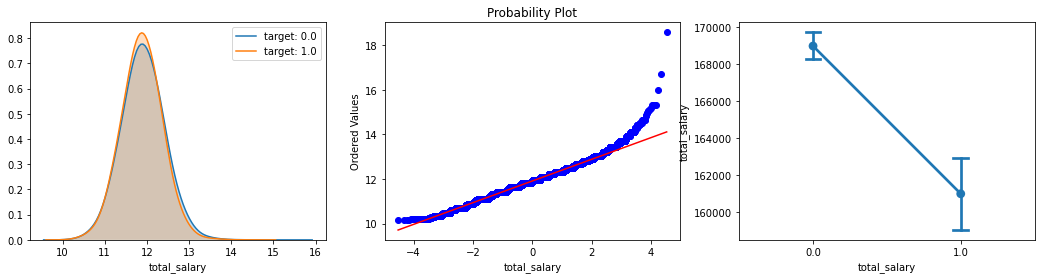

None

__Оценка признака «amt_application_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_application_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «num_instalment_number_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «num_instalment_number_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «cnt_payment_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

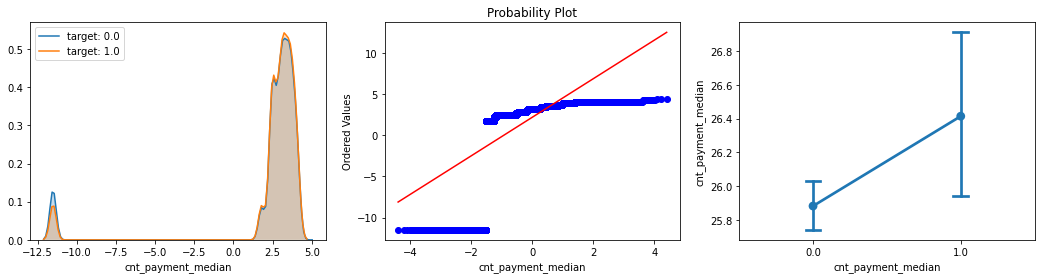

None

__Оценка признака «amt_credit_sum_overdue_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_overdue_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_payment_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_payment_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_first_due_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

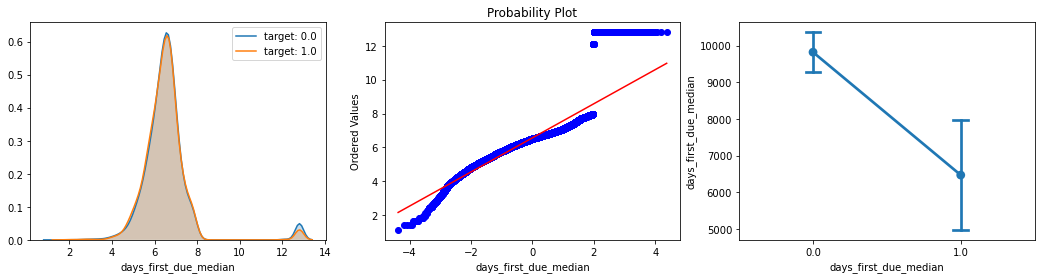

None

__Оценка признака «amt_annuity_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_annuity_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «sellerplace_area_mean» в разрезе целевой переменной__

_Удаляем слобец «sellerplace_area_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_product_type_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_product_type_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «bureau_id_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «bureau_id_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «external_scoring_rating_2» в разрезе целевой переменной__

_Привели к нормальному распределению_

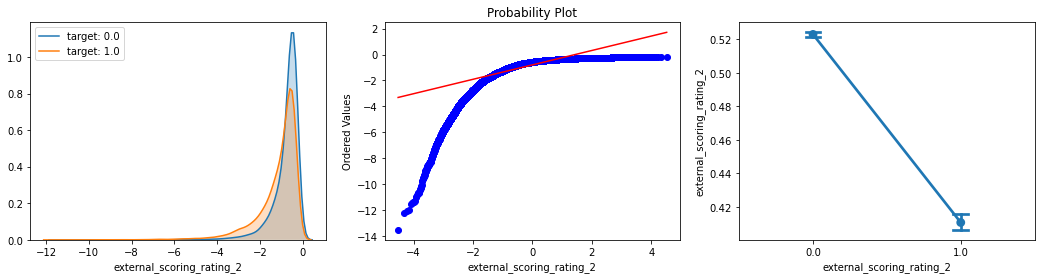

None

__Оценка признака «amount_credit_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

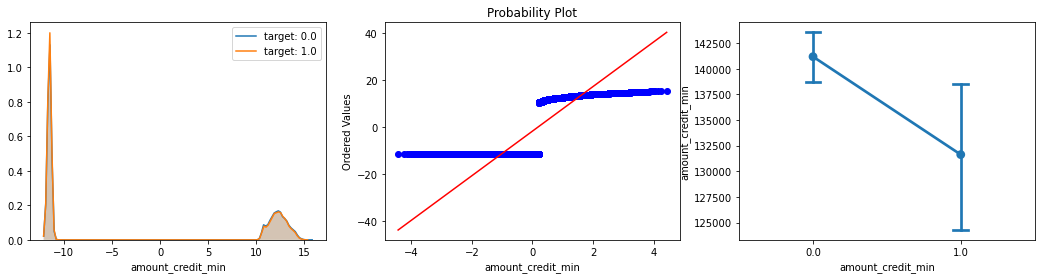

None

__Оценка признака «external_scoring_rating_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

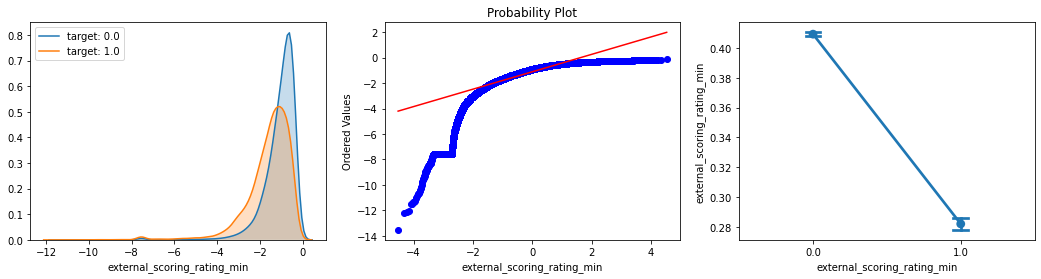

None

__Оценка признака «days_credit_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «credit_day_overdue_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_day_overdue_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «prev_application_number_max_x» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «prev_application_number_max_x» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_credit_update_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_update_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_payment_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_payment_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_termination_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

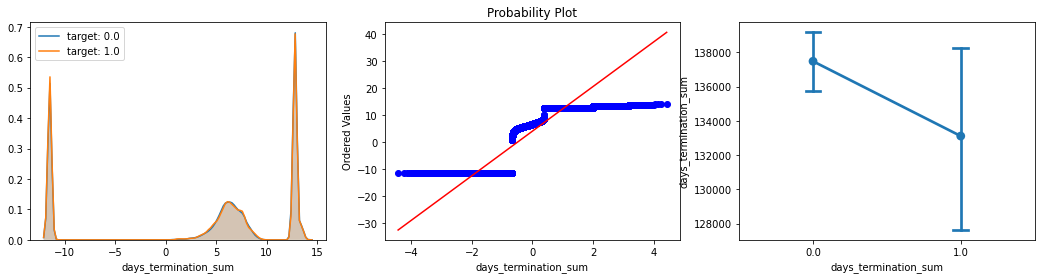

None

__Оценка признака «days_credit_enddate_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_enddate_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «cnt_payment_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «cnt_payment_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_credit_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_credit_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_contract_status_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

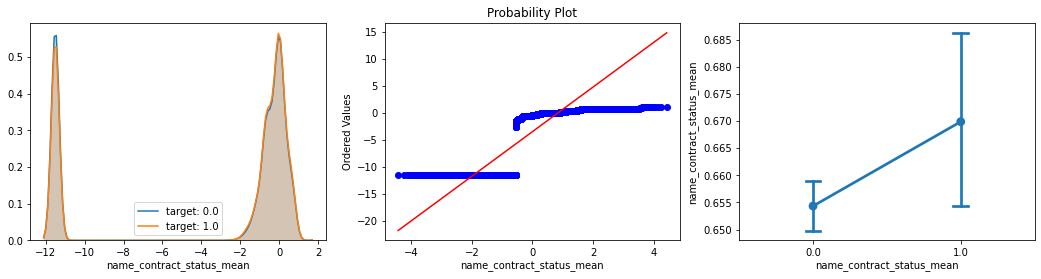

None

__Оценка признака «days_credit_enddate_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_enddate_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «sellerplace_area_sum» в разрезе целевой переменной__

_Удаляем слобец «sellerplace_area_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_instalment_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_instalment_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «ratio_salary_to_experience» в разрезе целевой переменной__

_Привели к нормальному распределению_

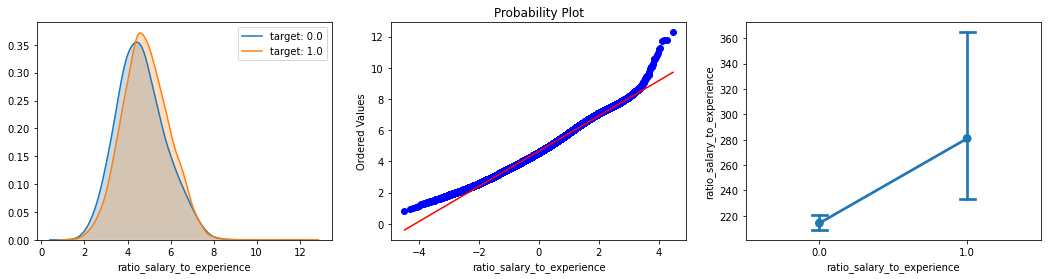

None

__Оценка признака «days_last_due_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

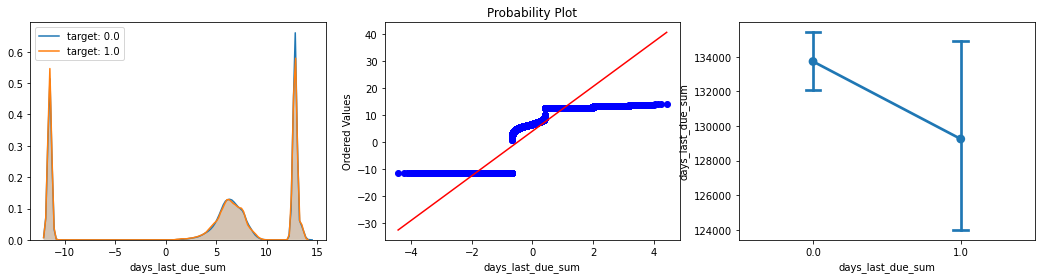

None

__Оценка признака «days_enddate_fact_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_enddate_fact_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_application_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_application_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «cnt_credit_prolong_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «cnt_credit_prolong_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_credit_update_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_update_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_on_last_job» в разрезе целевой переменной__

_Привели к нормальному распределению_

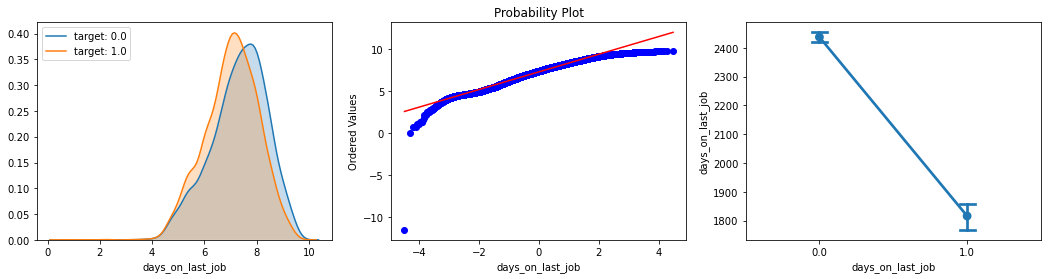

None

__Оценка признака «days_enddate_fact_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_enddate_fact_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_first_due_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

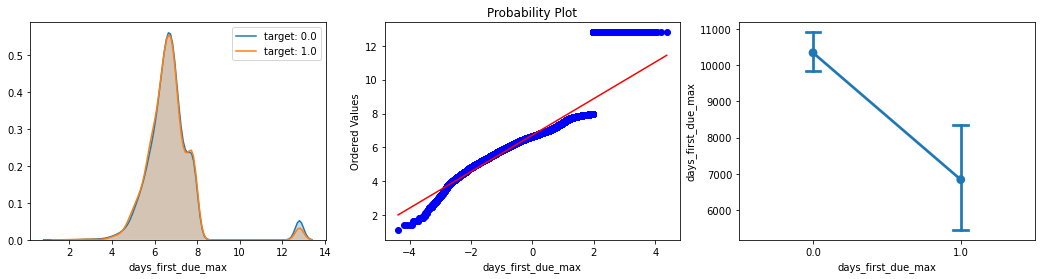

None

__Оценка признака «cnt_payment_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

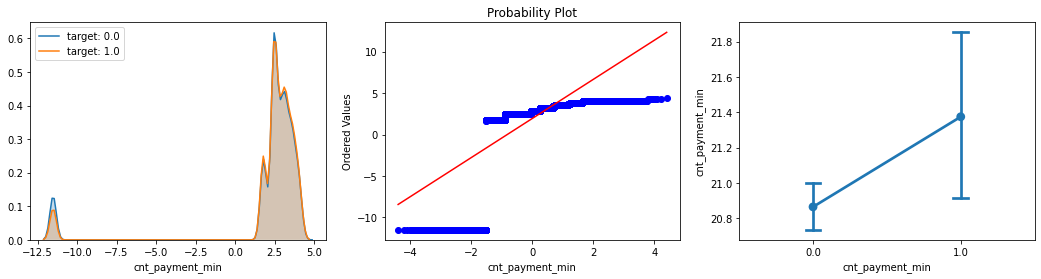

None

__Оценка признака «prev_application_number_sum_x» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «prev_application_number_sum_x» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_annuity_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_annuity_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_limit_sum» в разрезе целевой переменной__

_Удаляем слобец «amt_credit_sum_limit_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_decision_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_decision_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «num_instalment_number_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «num_instalment_number_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_max_overdue_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_max_overdue_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «bureau_id_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «bureau_id_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_last_due_1st_version_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_last_due_1st_version_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «credit_currency_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_currency_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_annuity_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_annuity_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_first_drawing_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

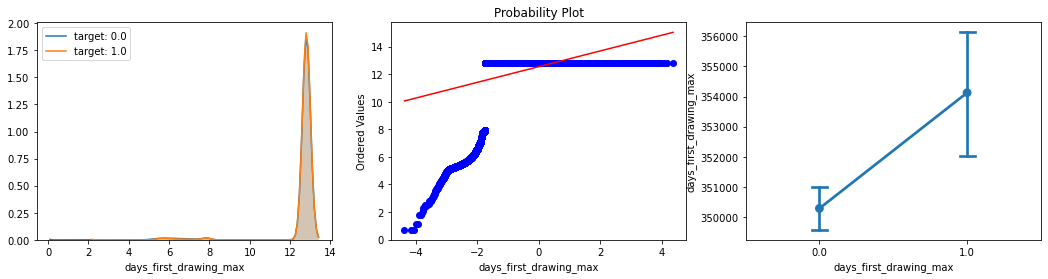

None

__Оценка признака «days_credit_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «sellerplace_area_max» в разрезе целевой переменной__

_Удаляем слобец «sellerplace_area_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «num_instalment_version_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «num_instalment_version_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «credit_day_overdue_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_day_overdue_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «age» в разрезе целевой переменной__

_Привели к нормальному распределению_

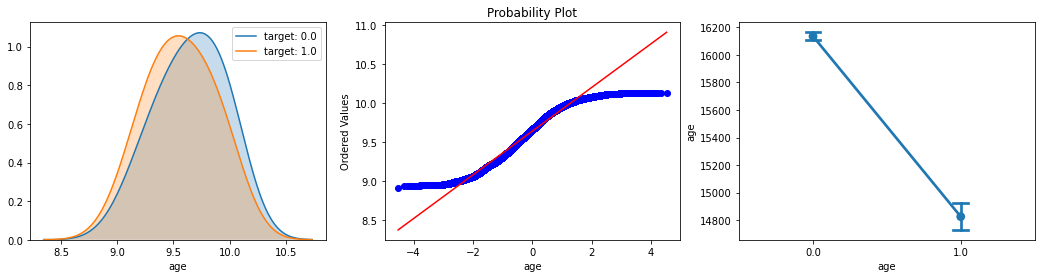

None

__Оценка признака «credit_active_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_active_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_yield_group_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_yield_group_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_last_due_1st_version_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_last_due_1st_version_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_overdue_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_overdue_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_annuity_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_annuity_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_portfolio_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_portfolio_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_contract_status_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_contract_status_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «num_instalment_version_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «num_instalment_version_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_credit_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_credit_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_goods_payment_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_goods_payment_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_termination_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_termination_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «external_scoring_rating_1» в разрезе целевой переменной__

_Привели к нормальному распределению_

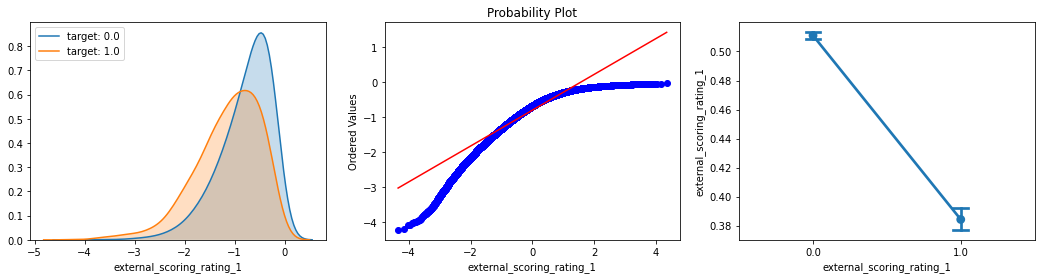

None

__Оценка признака «amt_instalment_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

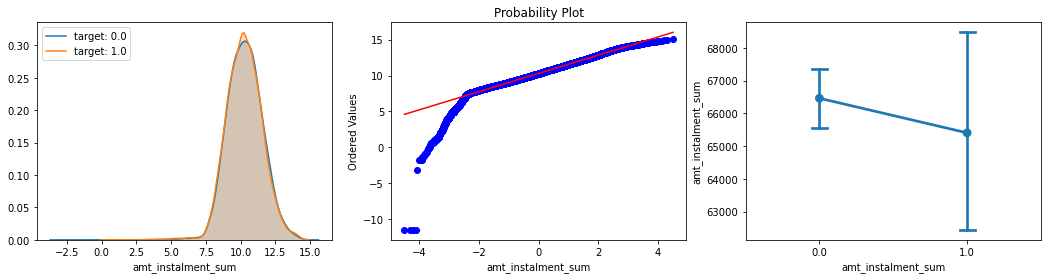

None

__Оценка признака «days_decision_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_decision_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_first_due_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

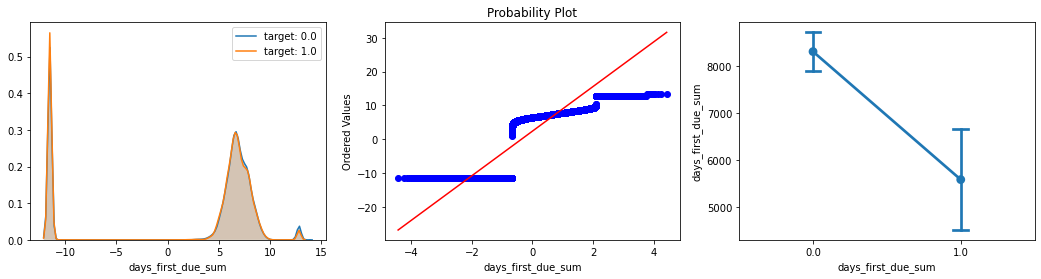

None

__Оценка признака «days_credit_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_credit_update_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_update_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_enddate_fact_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_enddate_fact_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «ratio_salary_to_age» в разрезе целевой переменной__

_Привели к нормальному распределению_

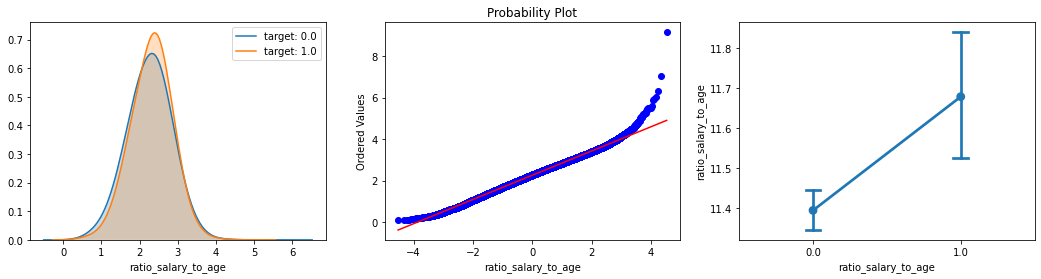

None

__Оценка признака «amt_credit_sum_limit_max» в разрезе целевой переменной__

_Удаляем слобец «amt_credit_sum_limit_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_credit_update_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_update_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «credit_day_overdue_min» в разрезе целевой переменной__

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


_Удаляем слобец «credit_day_overdue_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_debt_mean» в разрезе целевой переменной__

_Удаляем слобец «amt_credit_sum_debt_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_payment_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_payment_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_credit_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_credit_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_instalment_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_instalment_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «credit_active_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_active_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_credit_enddate_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_enddate_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_annuity_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_annuity_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_decision_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_decision_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_entry_payment_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_entry_payment_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_limit_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_limit_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «prev_application_number_min_x» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «prev_application_number_min_x» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_payment_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_payment_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_type_suite_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_type_suite_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «prev_application_number_mean_x» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «prev_application_number_mean_x» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_annuity_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_annuity_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_max_overdue_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_max_overdue_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_instalment_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

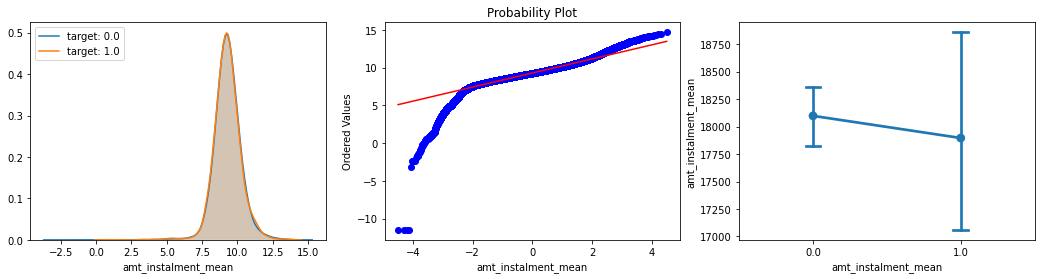

None

__Оценка признака «amt_annuity_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_annuity_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_max_overdue_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_max_overdue_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_payment_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

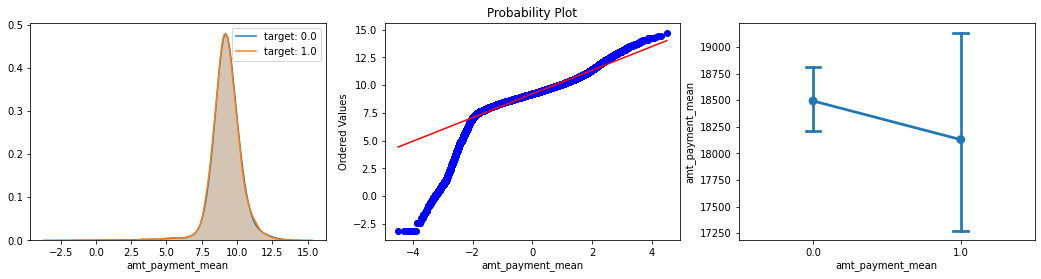

None

__Оценка признака «amt_payment_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_payment_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_limit_min» в разрезе целевой переменной__

_Удаляем слобец «amt_credit_sum_limit_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_annuity_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_annuity_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «num_instalment_version_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «num_instalment_version_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_last_due_median» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_last_due_median» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «credit_type_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_type_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_annuity_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_annuity_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «cnt_credit_prolong_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «cnt_credit_prolong_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_instalment_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_instalment_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «external_scoring_rating_var» в разрезе целевой переменной__

_Привели к нормальному распределению_

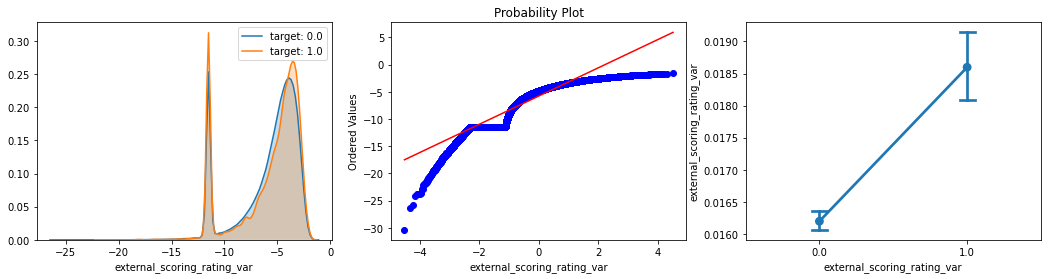

None

__Оценка признака «amount_credit_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_credit_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_credit» в разрезе целевой переменной__

_Привели к нормальному распределению_

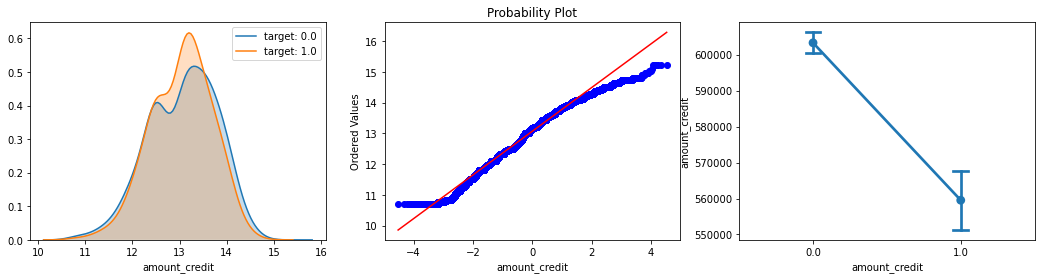

None

__Оценка признака «expected_total_loss_1» в разрезе целевой переменной__

_Привели к нормальному распределению_

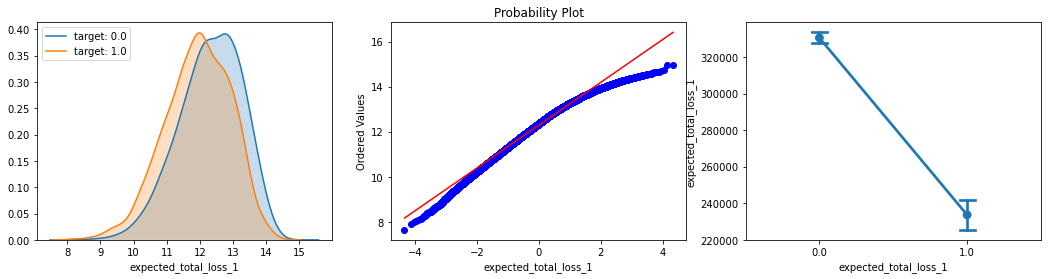

None

__Оценка признака «ratio_annuity_to_experience» в разрезе целевой переменной__

_Привели к нормальному распределению_

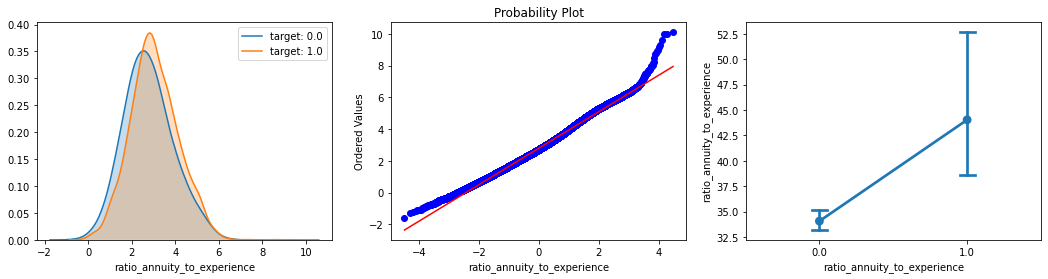

None

__Оценка признака «amt_credit_sum_debt_max» в разрезе целевой переменной__

_Удаляем слобец «amt_credit_sum_debt_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «prev_application_number_std_x» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «prev_application_number_std_x» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «credit_type_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_type_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «prev_application_number_y_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «prev_application_number_y_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «credit_type_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_type_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_last_due_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_last_due_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_annuity» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_annuity» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_credit_sum_min» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_credit_sum_min» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_client_type_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_client_type_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «prev_application_number_y_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «prev_application_number_y_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «name_type_suite_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «name_type_suite_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_last_due_max» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_last_due_max» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amount_credit_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amount_credit_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_last_due_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_last_due_mean» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_enddate_fact_sum» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_enddate_fact_sum» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_req_credit_bureau_year» в разрезе целевой переменной__

_Привели к нормальному распределению_

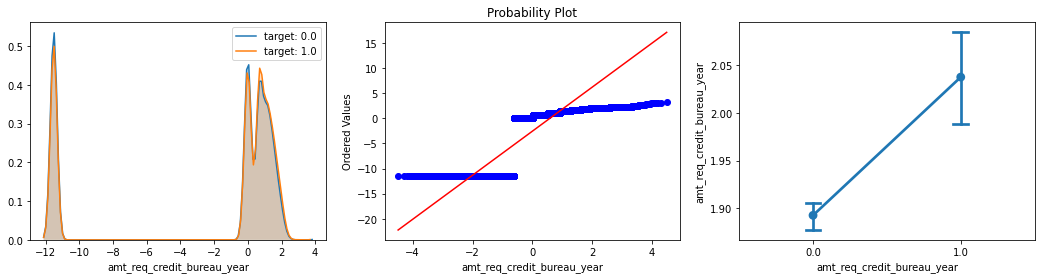

None

__Оценка признака «days_credit_update_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_credit_update_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «days_instalment_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «days_instalment_std» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «amt_instalment_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «amt_instalment_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «credit_day_overdue_count» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «credit_day_overdue_count» как несоответствующий U-критерию Манна-Уитни_

__Оценка признака «nflag_insured_on_approval_mean» в разрезе целевой переменной__

_Привели к нормальному распределению_

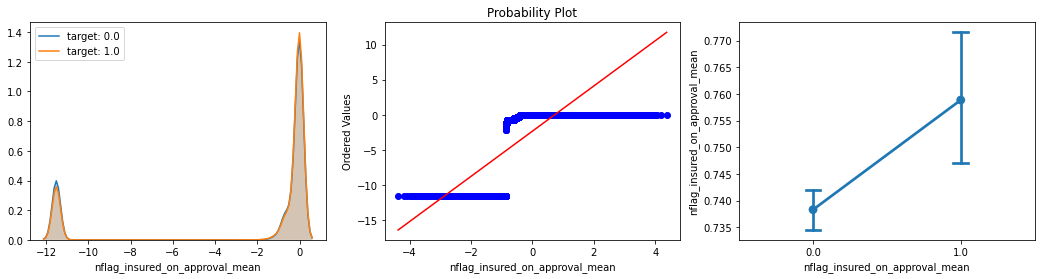

None

__Оценка признака «nflag_insured_on_approval_std» в разрезе целевой переменной__

_Привели к нормальному распределению_

_Удаляем слобец «nflag_insured_on_approval_std» как несоответствующий U-критерию Манна-Уитни_

## Обработка пропусков

table_id                                  0
application_number                        0
target                               165141
name_contract_type                        0
gender                                    0
childrens                             51519
total_salary                          51519
amount_credit                         51519
education_level                           0
family_status                             0
region_population                     51519
age                                   51519
days_on_last_job                      91629
own_car_age                          199200
flag_phone                            51519
family_size                           51521
external_scoring_rating_1            177508
external_scoring_rating_2             51998
external_scoring_rating_3             95926
amt_req_credit_bureau_mon             81717
amt_req_credit_bureau_qrt             81717
amt_req_credit_bureau_year            81717
credit_active_sum               

table_id                                  0
application_number                        0
target                               165141
name_contract_type                        0
gender                                    0
childrens                                 0
total_salary                              0
amount_credit                             0
education_level                           0
family_status                             0
region_population                         0
age                                       0
days_on_last_job                          0
own_car_age                               0
flag_phone                                0
family_size                               0
external_scoring_rating_1                 0
external_scoring_rating_2                 0
external_scoring_rating_3                 0
amt_req_credit_bureau_mon                 0
amt_req_credit_bureau_qrt                 0
amt_req_credit_bureau_year                0
credit_active_sum               

## Обработка выбросов

__Обработка признака «num_instalment_version_std»__

__Обработка признака «ratio_car_to_experience»__

__Обработка признака «amt_instalment_std»__

__Обработка признака «external_scoring_rating_mean»__

__Обработка признака «ratio_annuity_to_age»__

__Обработка признака «expected_total_loss_2»__

__Обработка признака «bki_kurtosis»__

__Обработка признака «total_salary_net»__

__Обработка признака «days_first_drawing_mean»__

__Обработка признака «amt_req_credit_bureau_qrt»__

__Обработка признака «name_type_suite_median»__

__Обработка признака «days_first_drawing_median»__

__Обработка признака «cnt_payment_mean»__

__Обработка признака «days_first_due_min»__

__Обработка признака «ratio_age_to_experience»__

__Обработка признака «nflag_insured_on_approval_min»__

__Обработка признака «amt_instalment_max»__

__Обработка признака «external_scoring_rating_1»__

__Обработка признака «amt_instalment_sum»__

__Обработка признака «expected_monthly_loss_1»__

__Обработка признака «cnt_credit_prolong_median»__

__Обработка признака «family_status»__

__Обработка признака «days_first_due_sum»__

__Обработка признака «name_payment_type_mean»__

__Обработка признака «days_first_due_mean»__

__Обработка признака «ratio_credit_to_age»__

__Обработка признака «code_reject_reason_median»__

__Обработка признака «total_salary»__

__Обработка признака «cnt_payment_median»__

__Обработка признака «name_portfolio_min»__

__Обработка признака «ratio_salary_to_age»__

__Обработка признака «cnt_payment_max»__

__Обработка признака «gender»__

__Обработка признака «days_first_due_median»__

__Обработка признака «amt_payment_max»__

__Обработка признака «days_decision_min»__

__Обработка признака «name_product_type_min»__

__Обработка признака «external_scoring_rating_2»__

__Обработка признака «amt_req_credit_bureau_mon»__

__Обработка признака «amount_credit_min»__

__Обработка признака «name_payment_type_min»__

__Обработка признака «days_last_due_1st_version_sum»__

__Обработка признака «external_scoring_rating_min»__

__Обработка признака «external_scoring_weighted»__

__Обработка признака «days_termination_sum»__

__Обработка признака «credit_active_sum»__

__Обработка признака «credit_type_max»__

__Обработка признака «credit_currency_sum»__

__Обработка признака «name_type_suite_max»__

__Обработка признака «amt_instalment_mean»__

__Обработка признака «amt_payment_mean»__

__Обработка признака «external_scoring_rating_3»__

__Обработка признака «bki_requests_count»__

__Обработка признака «ratio_salary_to_experience»__

__Обработка признака «ratio_credit_to_annuity»__

__Обработка признака «days_last_due_sum»__

__Обработка признака «days_first_drawing_min»__

__Обработка признака «expected_total_loss_3»__

__Обработка признака «amt_payment_std»__

__Обработка признака «external_scoring_rating_max»__

__Обработка признака «external_scoring_rating_var»__

__Обработка признака «family_size»__

__Обработка признака «name_contract_status_max»__

__Обработка признака «ratio_salary_to_region_population»__

__Обработка признака «amount_credit»__

__Обработка признака «days_on_last_job»__

__Обработка признака «expected_total_loss_1»__

__Обработка признака «ratio_annuity_to_experience»__

__Обработка признака «ratio_annuity_to_salary»__

__Обработка признака «days_first_due_max»__

__Обработка признака «name_portfolio_median»__

__Обработка признака «credit_currency_median»__

__Обработка признака «childrens»__

__Обработка признака «cnt_payment_min»__

__Обработка признака «code_reject_reason_max»__

__Обработка признака «prev_application_number_y_median»__

__Обработка признака «name_contract_status_sum»__

__Обработка признака «nflag_insured_on_approval_max»__

__Обработка признака «name_type_suite_min»__

__Обработка признака «cnt_credit_prolong_min»__

__Обработка признака «days_first_drawing_max»__

__Обработка признака «num_instalment_version_max»__

__Обработка признака «external_scoring_rating_nanmedian»__

__Обработка признака «expected_monthly_loss_2»__

__Обработка признака «own_car_age»__

__Обработка признака «name_portfolio_max»__

__Обработка признака «external_scoring_prod»__

__Обработка признака «nflag_insured_on_approval_median»__

__Обработка признака «flag_phone»__

__Обработка признака «age»__

__Обработка признака «credit_type_median»__

__Обработка признака «days_last_due_1st_version_max»__

__Обработка признака «amt_req_credit_bureau_year»__

__Обработка признака «education_level»__

__Обработка признака «region_population»__

__Обработка признака «ratio_car_to_age»__

__Обработка признака «ratio_credit_to_experience»__

__Обработка признака «expected_monthly_loss_3»__

__Обработка признака «nflag_insured_on_approval_mean»__

__Обработка признака «name_contract_status_mean»__

__Обработка признака «amt_payment_sum»__

## Подготовка фичей

__Обработка номинативных признаков__

_Нет признаков для обработки_

__Обработка категориальных признаков__

_Обработка признака «gender»_

_Признак «gender» обработан_

_Обработка признака «education_level»_

_Признак «education_level» обработан_

_Обработка признака «bki_requests_count»_

_Признак «bki_requests_count» обработан_

_Обработка признака «family_status»_

_Признак «family_status» обработан_

## Анализ признакового пространства

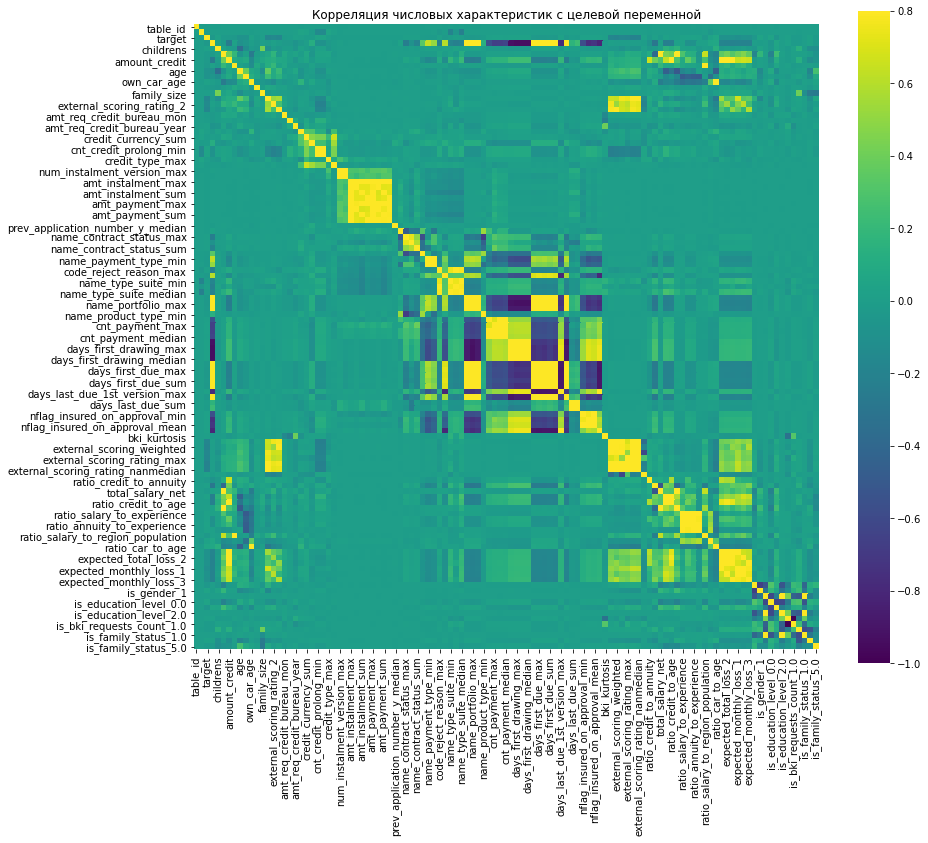

None

_Обработка признака «ratio_car_to_experience»_

_Обработка признака «num_instalment_version_std»_

_Обработка признака «amt_instalment_std»_

_Обработка признака «external_scoring_rating_mean»_

_Обработка признака «ratio_annuity_to_age»_

_Обработка признака «expected_total_loss_2»_

_Обработка признака «bki_kurtosis»_

_Обработка признака «is_gender_0»_

_Обработка признака «is_family_status_5.0»_

_Обработка признака «total_salary_net»_

_Обработка признака «days_first_drawing_mean»_

_Обработка признака «is_family_status_2.0»_

_Обработка признака «amt_req_credit_bureau_qrt»_

_Обработка признака «days_first_drawing_median»_

_Обработка признака «name_type_suite_median»_

_Обработка признака «cnt_payment_mean»_

_Обработка признака «days_first_due_min»_

_Обработка признака «ratio_age_to_experience»_

_Обработка признака «nflag_insured_on_approval_min»_

_Обработка признака «amt_instalment_max»_

_Обработка признака «amt_instalment_sum»_

_Обработка признака «external_scoring_rating_1»_

_Обработка признака «expected_monthly_loss_1»_

_Обработка признака «cnt_credit_prolong_median»_

_Обработка признака «ratio_credit_to_age»_

_Обработка признака «name_payment_type_mean»_

_Обработка признака «days_first_due_mean»_

_Обработка признака «days_first_due_sum»_

_Обработка признака «code_reject_reason_median»_

_Обработка признака «total_salary»_

_Обработка признака «cnt_payment_median»_

_Обработка признака «name_portfolio_min»_

_Обработка признака «ratio_salary_to_age»_

_Обработка признака «cnt_payment_max»_

_Обработка признака «days_first_due_median»_

_Обработка признака «amt_payment_max»_

_Обработка признака «days_decision_min»_

_Обработка признака «name_product_type_min»_

_Обработка признака «external_scoring_rating_2»_

_Обработка признака «amt_req_credit_bureau_mon»_

_Обработка признака «amount_credit_min»_

_Обработка признака «name_payment_type_min»_

_Обработка признака «days_last_due_1st_version_sum»_

_Обработка признака «external_scoring_rating_min»_

_Обработка признака «external_scoring_weighted»_

_Обработка признака «days_termination_sum»_

_Обработка признака «credit_active_sum»_

_Обработка признака «credit_type_max»_

_Обработка признака «credit_currency_sum»_

_Обработка признака «name_type_suite_max»_

_Обработка признака «amt_instalment_mean»_

_Обработка признака «amt_payment_mean»_

_Обработка признака «external_scoring_rating_3»_

_Обработка признака «is_gender_2»_

_Обработка признака «ratio_salary_to_experience»_

_Обработка признака «ratio_credit_to_annuity»_

_Обработка признака «days_last_due_sum»_

_Обработка признака «days_first_drawing_min»_

_Обработка признака «expected_total_loss_3»_

_Обработка признака «is_bki_requests_count_1.0»_

_Обработка признака «amt_payment_std»_

_Обработка признака «external_scoring_rating_max»_

_Обработка признака «external_scoring_rating_var»_

_Обработка признака «family_size»_

_Обработка признака «is_education_level_1.0»_

_Обработка признака «name_contract_status_max»_

_Обработка признака «ratio_salary_to_region_population»_

_Обработка признака «amount_credit»_

_Обработка признака «days_on_last_job»_

_Обработка признака «is_education_level_0.0»_

_Обработка признака «expected_total_loss_1»_

_Обработка признака «ratio_annuity_to_experience»_

_Обработка признака «ratio_annuity_to_salary»_

_Обработка признака «days_first_due_max»_

_Обработка признака «name_portfolio_median»_

_Обработка признака «cnt_payment_min»_

_Обработка признака «childrens»_

_Обработка признака «credit_currency_median»_

_Обработка признака «code_reject_reason_max»_

_Обработка признака «is_bki_requests_count_0.0»_

_Обработка признака «amt_payment_sum»_

_Обработка признака «prev_application_number_y_median»_

_Обработка признака «name_contract_status_sum»_

_Обработка признака «nflag_insured_on_approval_max»_

_Обработка признака «is_family_status_1.0»_

_Обработка признака «name_type_suite_min»_

_Обработка признака «cnt_credit_prolong_min»_

_Обработка признака «days_first_drawing_max»_

_Обработка признака «num_instalment_version_max»_

_Обработка признака «external_scoring_rating_nanmedian»_

_Обработка признака «expected_monthly_loss_2»_

_Обработка признака «own_car_age»_

_Обработка признака «name_portfolio_max»_

_Обработка признака «is_gender_1»_

_Обработка признака «external_scoring_prod»_

_Обработка признака «nflag_insured_on_approval_median»_

_Обработка признака «flag_phone»_

_Обработка признака «age»_

_Обработка признака «credit_type_median»_

_Обработка признака «days_last_due_1st_version_max»_

_Обработка признака «ratio_credit_to_experience»_

_Обработка признака «amt_req_credit_bureau_year»_

_Обработка признака «ratio_car_to_age»_

_Обработка признака «region_population»_

_Обработка признака «expected_monthly_loss_3»_

_Обработка признака «is_family_status_0.0»_

_Обработка признака «nflag_insured_on_approval_mean»_

_Обработка признака «name_contract_status_mean»_

_Обработка признака «is_education_level_2.0»_

_Признак «amt_instalment_std» удален_

_Признак «amt_instalment_std» удален_

_Признак «external_scoring_rating_mean» удален_

_Признак «external_scoring_rating_mean» удален_

_Признак «external_scoring_rating_mean» удален_

_Признак «external_scoring_rating_mean» удален_

_Признак «total_salary_net» удален_

_Признак «days_first_drawing_mean» удален_

_Признак «days_first_drawing_mean» удален_

_Признак «days_first_drawing_mean» удален_

_Признак «days_first_drawing_mean» удален_

_Признак «days_first_drawing_mean» удален_

_Признак «days_first_drawing_mean» удален_

_Признак «name_type_suite_median» удален_

_Признак «cnt_payment_mean» удален_

_Признак «cnt_payment_mean» удален_

_Признак «cnt_payment_mean» удален_

_Признак «days_first_due_min» удален_

_Признак «days_first_due_min» удален_

_Признак «days_first_due_min» удален_

_Признак «days_first_due_min» удален_

_Признак «days_first_due_min» удален_

_Признак «nflag_insured_on_approval_min» удален_

_Признак «amt_instalment_max» удален_

_Признак «amt_instalment_sum» удален_

_Признак «cnt_credit_prolong_median» удален_

_Признак «ratio_credit_to_age» удален_

_Признак «days_first_due_mean» удален_

_Признак «external_scoring_weighted» удален_

_Признак «days_termination_sum» удален_

_Признак «amt_instalment_mean» удален_

_Признак «is_gender_2» удален_

_Признак «is_bki_requests_count_1.0» удален_

_Признак «ratio_annuity_to_experience» удален_

## Стандартизация признакового пространства

## Отбор признаков

[22:27:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.70800	valid-auc:0.69435
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.74029	valid-auc:0.70403
[20]	train-auc:0.75635	valid-auc:0.70904
[30]	train-auc:0.77364	valid-auc:0.71215
[40]	train-auc:0.79278	valid-auc:0.71575
[50]	train-auc:0.80647	valid-auc:0.71834
[60]	train-auc:0.82185	valid-auc:0.72012
[70]	train-auc:0.83275	valid-auc:0.71972
Stopping. Best iteration:
[58]	train-auc:0.81851	valid-auc:0.72030



100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:08<00:00,  8.49it/s]


external_scoring_rating_mean         0.100654
ratio_credit_to_annuity              0.021108
is_gender_1                          0.005220
is_education_level_1.0               0.004175
external_scoring_rating_max          0.003818
age                                  0.003603
days_on_last_job                     0.003281
ratio_car_to_experience              0.002009
ratio_age_to_experience              0.002002
ratio_credit_to_age                  0.001730
ratio_annuity_to_experience          0.001706
region_population                    0.001517
ratio_salary_to_age                  0.001500
total_salary_net                     0.001374
ratio_annuity_to_age                 0.001231
expected_monthly_loss_3              0.001222
expected_total_loss_1                0.001115
external_scoring_rating_var          0.001072
ratio_salary_to_experience           0.001065
days_first_drawing_mean              0.000957
external_scoring_rating_2            0.000927
own_car_age                       

_Признак «amt_req_credit_bureau_mon» удален_

_Признак «credit_active_sum» удален_

_Признак «is_family_status_5.0» удален_

_Признак «num_instalment_version_max» удален_

_Признак «is_gender_2» удален_

_Признак «family_size» удален_

_Признак «name_portfolio_min» удален_

_Признак «name_type_suite_median» удален_

_Признак «name_product_type_min» удален_

_Признак «flag_phone» удален_

_Признак «is_family_status_1.0» удален_

_Признак «credit_currency_sum» удален_

table_id  application_number  target  name_contract_type  childrens  \
0         0           123687442     0.0                   0   1.745487   
1         1           123597908     1.0                   0  -0.018904   
2         2           123526683     0.0                   0  -0.704564   
3         3           123710391     1.0                   0  -0.704564   
4         4           123590329     1.0                   0  -0.029450   

   region_population       age  days_on_last_job  own_car_age  \
0          -0.142007 -0.077231         -0.439118    -0.257174   
1           0.005468  0.032808         -0.001546     0.013814   
2           0.444185  1.409265          0.580213     0.311236   
3           0.841117  1.608433          0.252639     0.232768   
4          -0.009001  0.019635          0.024371     0.032179   

   external_scoring_rating_1  external_scoring_rating_2  \
0                   1.130725                   0.768380   
1                   0.004331                  -0.004937   
2                  -0.276421                   0.979589   
3                  -2.109394                  -1.998034   
4                  -0.003130                  -0.001483   

   amt_req_credit_bureau_qrt  amt_req_credit_bureau_year  \
0                  -0.523194                    0.077623   
1                  -0.001410                    0.022026   
2                  -0.523194                    1.398705   
3                  -0.523194                   -1.243458   
4                   0.026192                    0.015426   

   credit_currency_median  cnt_credit_prolong_median  credit_type_max  \
0               -0.325209                  -0.297129        -0.031729   
1               -0.325209                  -0.297129        -0.031729   
2               -0.325209                  -0.297129        -0.031729   
3               -0.325209                  -0.297129        -0.031729   
4               -0.325209                  -0.297129        -0.031729   

   credit_type_median  num_instalment_version_std  amt_instalment_mean  \
0           -0.529172                   -0.861759            -0.654977   
1           -0.529172                   -0.183570            -0.337993   
2           -0.529172                    0.717994             0.212990   
3           -0.529172                   -0.170953            -0.893986   
4           -0.529172                   -0.861759            -0.384317   

   amt_instalment_sum  amt_instalment_std  prev_application_number_y_median  \
0           -0.479679           -0.540678                          0.044691   
1           -0.655978            0.073215                          0.021001   
2            0.232684            0.326172                         -0.019677   
3           -0.770058            0.056387                         -0.014681   
4           -0.257541           -0.721943                          0.174269   

   amount_credit_min  name_contract_status_max  name_contract_status_mean  \
0          -0.053786                  0.072599                   0.067905   
1           2.878287                  0.875092                   0.796222   
2          -0.712570                  0.875092                   0.204159   
3          -0.062466                  0.098822                   0.119924   
4          -0.712570                  0.875092                   2.690826   

   name_contract_status_sum  days_decision_min  name_payment_type_min  \
0                  0.021950          -0.083485              -0.148044   
1                 -0.251812           0.256689              -0.773244   
2                  0.115186          -0.029942              -0.773244   
3                  0.020392          -0.150041              -0.131899   
4                  2.317176          -0.762096              -0.773244   

   name_payment_type_mean  code_reject_reason_max  code_reject_reason_median  \
0               -0.111481                0.908890                   0.404443   
1               -1.666816     

## Реализация baseline

__Обучение модели (KFold)__

Sun Oct 25 22:27:21 2020, Cross-Validation, 110093 rows, 63 cols
0:	test: 0.5790799	test1: 0.5807727	best: 0.5807727 (0)	total: 113ms	remaining: 3m 46s
10:	test: 0.6943879	test1: 0.6843582	best: 0.6888260 (4)	total: 324ms	remaining: 58.6s
20:	test: 0.6996459	test1: 0.6896044	best: 0.6908252 (16)	total: 544ms	remaining: 51.3s
30:	test: 0.7035257	test1: 0.6934556	best: 0.6934556 (30)	total: 749ms	remaining: 47.5s
40:	test: 0.7052469	test1: 0.6958088	best: 0.6960596 (39)	total: 982ms	remaining: 46.9s
50:	test: 0.7055517	test1: 0.6953670	best: 0.6960596 (39)	total: 1.19s	remaining: 45.5s
60:	test: 0.7067853	test1: 0.6971794	best: 0.6971794 (60)	total: 1.4s	remaining: 44.5s
70:	test: 0.7075004	test1: 0.6973560	best: 0.6973560 (70)	total: 1.61s	remaining: 43.7s
80:	test: 0.7082205	test1: 0.6970990	best: 0.6975682 (71)	total: 1.81s	remaining: 43s
90:	test: 0.7088544	test1: 0.6977140	best: 0.6977140 (90)	total: 2.01s	remaining: 42.1s
100:	test: 0.7093571	test1: 0.6981212	best: 0.6984198 (96)	t

910:	test: 0.7471543	test1: 0.7178817	best: 0.7178851 (908)	total: 19.2s	remaining: 22.9s
920:	test: 0.7475119	test1: 0.7179945	best: 0.7179945 (920)	total: 19.4s	remaining: 22.7s
930:	test: 0.7478775	test1: 0.7180599	best: 0.7180599 (930)	total: 19.6s	remaining: 22.5s
940:	test: 0.7481612	test1: 0.7180736	best: 0.7181116 (937)	total: 19.8s	remaining: 22.3s
950:	test: 0.7484921	test1: 0.7180845	best: 0.7181367 (947)	total: 20s	remaining: 22.1s
960:	test: 0.7488533	test1: 0.7181675	best: 0.7181821 (957)	total: 20.2s	remaining: 21.9s
970:	test: 0.7491912	test1: 0.7182507	best: 0.7182507 (970)	total: 20.5s	remaining: 21.7s
980:	test: 0.7495687	test1: 0.7182674	best: 0.7182975 (973)	total: 20.7s	remaining: 21.5s
990:	test: 0.7498900	test1: 0.7183295	best: 0.7183368 (988)	total: 20.9s	remaining: 21.3s
1000:	test: 0.7501670	test1: 0.7184045	best: 0.7184170 (999)	total: 21.1s	remaining: 21.1s
1010:	test: 0.7504797	test1: 0.7184387	best: 0.7184387 (1010)	total: 21.3s	remaining: 20.8s
1020:	tes

300:	test: 0.7224491	test1: 0.7104897	best: 0.7104897 (300)	total: 5.99s	remaining: 33.8s
310:	test: 0.7228949	test1: 0.7107819	best: 0.7108084 (309)	total: 6.19s	remaining: 33.6s
320:	test: 0.7232606	test1: 0.7109911	best: 0.7110003 (318)	total: 6.39s	remaining: 33.4s
330:	test: 0.7239009	test1: 0.7113376	best: 0.7113376 (330)	total: 6.58s	remaining: 33.2s
340:	test: 0.7244408	test1: 0.7116313	best: 0.7116867 (338)	total: 6.78s	remaining: 33s
350:	test: 0.7250222	test1: 0.7119474	best: 0.7119474 (350)	total: 6.97s	remaining: 32.8s
360:	test: 0.7255252	test1: 0.7122869	best: 0.7122869 (360)	total: 7.17s	remaining: 32.6s
370:	test: 0.7259500	test1: 0.7124770	best: 0.7124866 (369)	total: 7.37s	remaining: 32.3s
380:	test: 0.7264629	test1: 0.7127106	best: 0.7127106 (380)	total: 7.57s	remaining: 32.2s
390:	test: 0.7271531	test1: 0.7132057	best: 0.7132057 (390)	total: 7.76s	remaining: 31.9s
400:	test: 0.7276064	test1: 0.7134601	best: 0.7134601 (400)	total: 7.96s	remaining: 31.7s
410:	test: 0

1210:	test: 0.7561190	test1: 0.7196314	best: 0.7196314 (1210)	total: 24.5s	remaining: 16s
1220:	test: 0.7564401	test1: 0.7196415	best: 0.7196602 (1219)	total: 24.8s	remaining: 15.8s
1230:	test: 0.7567462	test1: 0.7196675	best: 0.7196808 (1225)	total: 25s	remaining: 15.6s
1240:	test: 0.7570659	test1: 0.7197145	best: 0.7197163 (1237)	total: 25.2s	remaining: 15.4s
1250:	test: 0.7573655	test1: 0.7197373	best: 0.7197373 (1250)	total: 25.4s	remaining: 15.2s
1260:	test: 0.7577261	test1: 0.7197167	best: 0.7197682 (1254)	total: 25.7s	remaining: 15s
1270:	test: 0.7579914	test1: 0.7197531	best: 0.7197682 (1254)	total: 25.9s	remaining: 14.8s
1280:	test: 0.7583036	test1: 0.7198452	best: 0.7198452 (1280)	total: 26.1s	remaining: 14.6s
1290:	test: 0.7586251	test1: 0.7199089	best: 0.7199089 (1290)	total: 26.3s	remaining: 14.4s
1300:	test: 0.7589205	test1: 0.7199453	best: 0.7199499 (1299)	total: 26.5s	remaining: 14.2s
1310:	test: 0.7592339	test1: 0.7199898	best: 0.7200056 (1307)	total: 26.7s	remaining: 

280:	test: 0.7184659	test1: 0.7153202	best: 0.7153309 (279)	total: 5.56s	remaining: 34s
290:	test: 0.7189802	test1: 0.7156905	best: 0.7156905 (290)	total: 5.75s	remaining: 33.8s
300:	test: 0.7194909	test1: 0.7161153	best: 0.7161153 (300)	total: 5.95s	remaining: 33.6s
310:	test: 0.7200931	test1: 0.7167604	best: 0.7167604 (310)	total: 6.14s	remaining: 33.4s
320:	test: 0.7206315	test1: 0.7172529	best: 0.7172529 (320)	total: 6.34s	remaining: 33.2s
330:	test: 0.7211564	test1: 0.7176433	best: 0.7176524 (329)	total: 6.54s	remaining: 33s
340:	test: 0.7216989	test1: 0.7181039	best: 0.7181039 (340)	total: 6.74s	remaining: 32.8s
350:	test: 0.7221281	test1: 0.7183936	best: 0.7183936 (350)	total: 6.93s	remaining: 32.5s
360:	test: 0.7226724	test1: 0.7187190	best: 0.7187190 (360)	total: 7.13s	remaining: 32.4s
370:	test: 0.7231973	test1: 0.7189839	best: 0.7189839 (370)	total: 7.32s	remaining: 32.1s
380:	test: 0.7237684	test1: 0.7192150	best: 0.7192150 (380)	total: 7.53s	remaining: 32s
390:	test: 0.724

1200:	test: 0.7540666	test1: 0.7259439	best: 0.7259777 (1173)	total: 24s	remaining: 16s
1210:	test: 0.7543799	test1: 0.7259862	best: 0.7259862 (1210)	total: 24.2s	remaining: 15.8s
1220:	test: 0.7547184	test1: 0.7259584	best: 0.7259967 (1215)	total: 24.4s	remaining: 15.6s
1230:	test: 0.7550744	test1: 0.7259457	best: 0.7259967 (1215)	total: 24.6s	remaining: 15.4s
1240:	test: 0.7553568	test1: 0.7259861	best: 0.7259967 (1215)	total: 24.8s	remaining: 15.2s
1250:	test: 0.7557041	test1: 0.7261062	best: 0.7261062 (1250)	total: 25s	remaining: 15s
1260:	test: 0.7560497	test1: 0.7261530	best: 0.7261574 (1259)	total: 25.2s	remaining: 14.8s
1270:	test: 0.7563673	test1: 0.7262468	best: 0.7262572 (1268)	total: 25.4s	remaining: 14.6s
1280:	test: 0.7566896	test1: 0.7263314	best: 0.7263314 (1280)	total: 25.6s	remaining: 14.4s
1290:	test: 0.7570318	test1: 0.7263744	best: 0.7263860 (1287)	total: 25.8s	remaining: 14.2s
1300:	test: 0.7574202	test1: 0.7263179	best: 0.7263860 (1287)	total: 26s	remaining: 14s


410:	test: 0.7273682	test1: 0.7089937	best: 0.7089937 (410)	total: 8.34s	remaining: 32.3s
420:	test: 0.7278437	test1: 0.7090769	best: 0.7090892 (415)	total: 8.54s	remaining: 32s
430:	test: 0.7282792	test1: 0.7091626	best: 0.7091626 (430)	total: 8.74s	remaining: 31.8s
440:	test: 0.7286622	test1: 0.7093938	best: 0.7093938 (440)	total: 8.94s	remaining: 31.6s
450:	test: 0.7291259	test1: 0.7095847	best: 0.7095847 (450)	total: 9.13s	remaining: 31.3s
460:	test: 0.7295622	test1: 0.7097365	best: 0.7097365 (460)	total: 9.33s	remaining: 31.1s
470:	test: 0.7300069	test1: 0.7099062	best: 0.7099062 (470)	total: 9.52s	remaining: 30.9s
480:	test: 0.7303312	test1: 0.7100726	best: 0.7100726 (480)	total: 9.72s	remaining: 30.7s
490:	test: 0.7307253	test1: 0.7102090	best: 0.7102090 (490)	total: 9.92s	remaining: 30.5s
500:	test: 0.7311049	test1: 0.7104367	best: 0.7104367 (500)	total: 10.1s	remaining: 30.3s
510:	test: 0.7315613	test1: 0.7106993	best: 0.7106993 (510)	total: 10.3s	remaining: 30.1s
520:	test: 0

1320:	test: 0.7582329	test1: 0.7157208	best: 0.7157526 (1287)	total: 26.6s	remaining: 13.7s
1330:	test: 0.7585644	test1: 0.7157563	best: 0.7157563 (1330)	total: 26.8s	remaining: 13.5s
1340:	test: 0.7588801	test1: 0.7158434	best: 0.7158434 (1340)	total: 27s	remaining: 13.3s
1350:	test: 0.7592072	test1: 0.7157953	best: 0.7158434 (1340)	total: 27.2s	remaining: 13.1s
1360:	test: 0.7595175	test1: 0.7157893	best: 0.7158434 (1340)	total: 27.4s	remaining: 12.9s
1370:	test: 0.7597915	test1: 0.7158068	best: 0.7158434 (1340)	total: 27.6s	remaining: 12.7s
1380:	test: 0.7600814	test1: 0.7158645	best: 0.7158645 (1380)	total: 27.8s	remaining: 12.5s
1390:	test: 0.7604435	test1: 0.7158439	best: 0.7158820 (1386)	total: 28s	remaining: 12.3s
1400:	test: 0.7607433	test1: 0.7159282	best: 0.7159282 (1400)	total: 28.2s	remaining: 12.1s
1410:	test: 0.7610081	test1: 0.7158841	best: 0.7159313 (1401)	total: 28.4s	remaining: 11.9s
1420:	test: 0.7612943	test1: 0.7159125	best: 0.7159313 (1401)	total: 28.6s	remaining

500:	test: 0.7307594	test1: 0.7146767	best: 0.7146767 (500)	total: 10s	remaining: 30s
510:	test: 0.7311320	test1: 0.7147942	best: 0.7147942 (510)	total: 10.2s	remaining: 29.7s
520:	test: 0.7315593	test1: 0.7150152	best: 0.7150152 (520)	total: 10.4s	remaining: 29.6s
530:	test: 0.7319122	test1: 0.7151116	best: 0.7151327 (528)	total: 10.6s	remaining: 29.3s
540:	test: 0.7322777	test1: 0.7153086	best: 0.7153136 (539)	total: 10.8s	remaining: 29.1s
550:	test: 0.7327309	test1: 0.7155243	best: 0.7155243 (550)	total: 11s	remaining: 28.9s
560:	test: 0.7331126	test1: 0.7156696	best: 0.7156965 (557)	total: 11.2s	remaining: 28.7s
570:	test: 0.7334856	test1: 0.7158751	best: 0.7158751 (570)	total: 11.4s	remaining: 28.5s
580:	test: 0.7338535	test1: 0.7160041	best: 0.7160041 (580)	total: 11.6s	remaining: 28.3s
590:	test: 0.7342269	test1: 0.7161496	best: 0.7161532 (589)	total: 11.8s	remaining: 28.1s
600:	test: 0.7346336	test1: 0.7163080	best: 0.7163080 (600)	total: 12s	remaining: 27.9s
610:	test: 0.73497

1410:	test: 0.7608301	test1: 0.7211687	best: 0.7211687 (1410)	total: 28.5s	remaining: 11.9s
1420:	test: 0.7610934	test1: 0.7211774	best: 0.7212146 (1414)	total: 28.8s	remaining: 11.7s
1430:	test: 0.7614095	test1: 0.7212702	best: 0.7212706 (1426)	total: 29s	remaining: 11.5s
1440:	test: 0.7617292	test1: 0.7213293	best: 0.7213293 (1440)	total: 29.2s	remaining: 11.3s
1450:	test: 0.7620006	test1: 0.7213447	best: 0.7213447 (1450)	total: 29.4s	remaining: 11.1s
1460:	test: 0.7622847	test1: 0.7213649	best: 0.7213670 (1459)	total: 29.6s	remaining: 10.9s
1470:	test: 0.7626003	test1: 0.7214014	best: 0.7214057 (1468)	total: 29.8s	remaining: 10.7s
1480:	test: 0.7628508	test1: 0.7214336	best: 0.7214336 (1480)	total: 30s	remaining: 10.5s
1490:	test: 0.7631240	test1: 0.7214249	best: 0.7214451 (1481)	total: 30.2s	remaining: 10.3s
1500:	test: 0.7633894	test1: 0.7214535	best: 0.7214825 (1498)	total: 30.4s	remaining: 10.1s
1510:	test: 0.7636818	test1: 0.7214958	best: 0.7214999 (1509)	total: 30.6s	remaining

__Подготовка прогноза__

app_1  app_2  app_3
0           0    0.0    0.0
1           0    0.0    1.0
2           0    0.0    0.0
3           0    0.0    1.0
4           0    0.0    1.0
...       ...    ...    ...
110088      0    0.0    0.0
110089      0    0.0    0.0
110090      0    0.0    0.0
110091      0    0.0    0.0
110092      1    0.0    0.0

[110093 rows x 3 columns]

0.0    109999
1.0        94
Name: app_2, dtype: int64

0.0    101196
1.0      8897
Name: app_3, dtype: int64

__Подготовка прогноза__

__Сохранение результата__

APPLICATION_NUMBER    TARGET
110093                   0  0.057660
110094                   0  0.202376
110095                   1  0.199487
110096                   0  0.079275
110097                   0  0.022247
...                    ...       ...
275229                   0  0.084922
275230                   0  0.047680
275231                   0  0.084035
275232                   0  0.014955
275233                   0  0.059715

[165141 rows x 2 columns]

Сохранено: geekbrains-competitive-data-analysis/baseline_submit.csv


In [34]:
# Проблема с агрегированием, пока временно отключил. Оставил только "хорошие" таблицы.
# df = entry('test.csv', 'train.csv', 'client_profile.csv', 'bki.csv', 'payments.csv', 'applications_history.csv')
entry(create_client_profile_features,
      'baseline_submit.csv', 
      'test.csv', 
      'train.csv', 
      'client_profile.csv',
      'bki.csv',
      'payments.csv',
      'applications_history.csv'
     )

__Выводы:__
    1. При разных запусках при одних и тех же параметрах точность скачет в полпроцента. Надо несколько раз запустить, тчобы получить лучший результат. Добился стабильной работы алгоритма с погрешностью в 4-м знаке.
    2. Если отключить предварительную обработку данных, то точность опять же увеличится в 1 %, что вобщем-то и понятно (результат в лидерборде). Тут два варианта почему: первый - данные уже были предварительно подготовлены и второй - в физическом эксперименте, если мы как-то меняем данные, то наша средняя начинает "уходить" от истинного значения.
    3. В целом алгоритм работает стабильно и с любыми данными (проверено), подкруткой параметров, которые вынесены в отдельную ячейку можно добиться неплохой точности.
    4. Не все графики удалось вывести.

__TODO:__
    1. Отрефакторить (есть местами код, который "дурно пахнет").
    2. Перенести код в отдельный модуль и адаптировать запуск вне зависимости от среды исполнения и так, чтобы можно было запускать алгоритм на проде.
    3. Архитектуру переписать на классы.
    4. Для унификации и возможности вывода графиков и прочего использовать поведенческий паттерн проектирования "Strategy" (если мы работаем с консолью Jupiter, то выводить красивые графики, в противном случае не выводить)
    5. Реализовать выполнение пользовательских функций обработки данных по типу функции create_client_profile_features с использованием паттерна "Observer".
    6. Для сохранения наилучших моделей и параметров их настроек использовать паттерн проектирования "Memento"
    7. Для гибкой работы алгоритма с различными типами моделей использовать паттерны проектирования "Chain of Command", "Template Method" и "State".
    8. Подключить другие модели помимо catboost.
    9. Реализовать "ансамблирование моделей", пока не получилось.
    10. Сделать прогонку основного алготима до 10 раз (задавать через параметры) и выбор наилучшего результата и модели.
    11. Сделать автоподбор параметров запуска, алгоритм будет работать существенно дольше, но это позволит более точно подобрать параметры с наиболее лучшим результатом.
    12. Сделать множественную классификацию.
    13. Сделать кластеризацию.
    14. Сделать регрессию.
    15. Дополнить алгоритм классическими методами аппроксимации.
    16. Написать веб-морду.